# Simulation 2: Simulate trajectory + batch effect

In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
from utils import cosine_sim
from simulation import simulate_expression_data_groups, combine_adatas_by_gene_dimension
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
proj_name = "simulation2"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

cpu


## 0. Simulate base gene expression matrix without batch

## 0.1 Simulate continuous expression level change 

<Axes: >

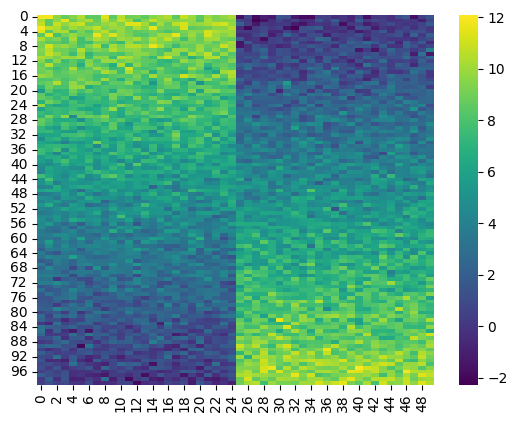

In [5]:
import seaborn as sns
from simulation import simulate_gradual_change_expression
# Simulate gradual change
group_key = 'time'
ngenes_ct = 50
ncells = 100     
adata_ct = simulate_gradual_change_expression(num_genes=ngenes_ct, num_cells=ncells, direction='both', time_key=group_key, max_expression=10, noise_level=1.0)

sns.heatmap(adata_ct.X, cmap='viridis')

In [6]:
import importlib
importlib.reload(ccd)

<module 'Concord' from '/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/Concord/__init__.py'>

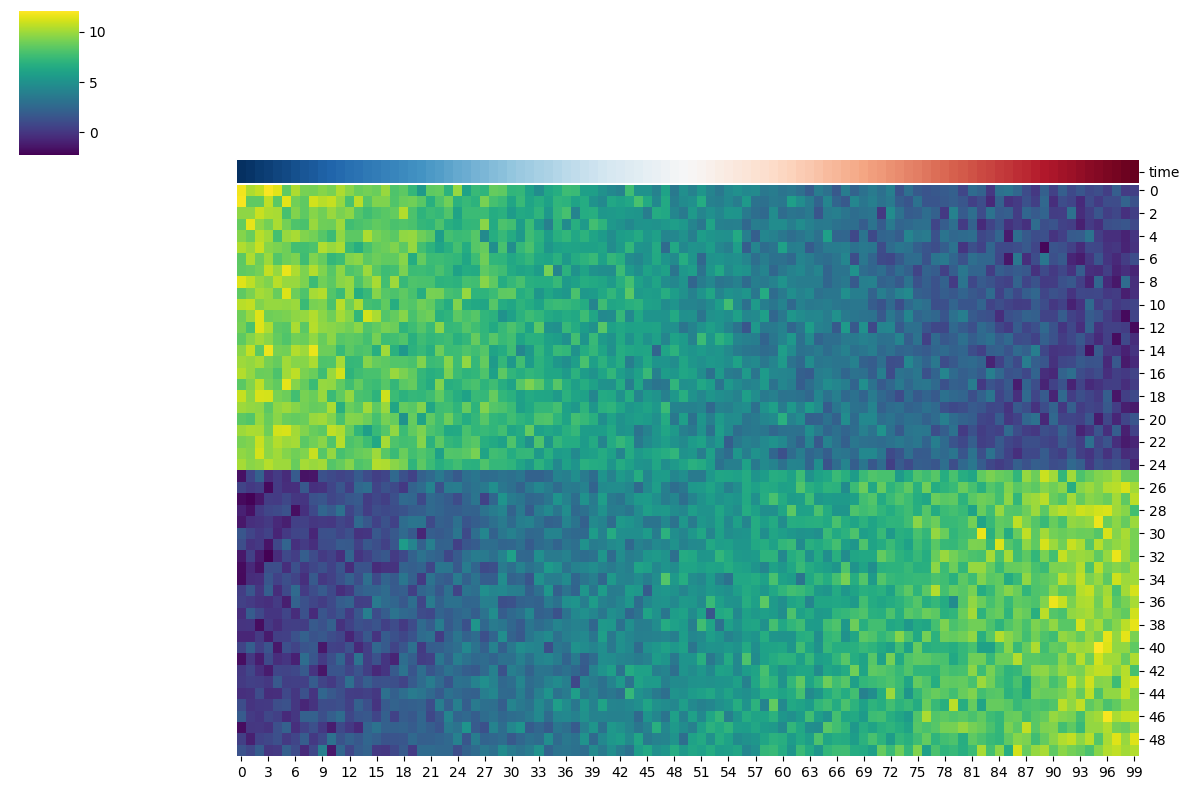

In [7]:
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.pl.heatmap_with_annotations(adata_ct, val='X', obs_keys=[group_key], cluster_cols=False, cluster_rows=False, cmap='viridis', save_path=save_dir/f'ct_heatmap_{file_suffix}.png') 

In [8]:
n_pcs = min(adata_ct.n_obs, adata_ct.n_vars)-1
sc.pp.pca(adata_ct, n_comps=n_pcs)
sc.pp.neighbors(adata_ct, n_neighbors=15, n_pcs=n_pcs)
sc.tl.umap(adata_ct, min_dist=0.1)

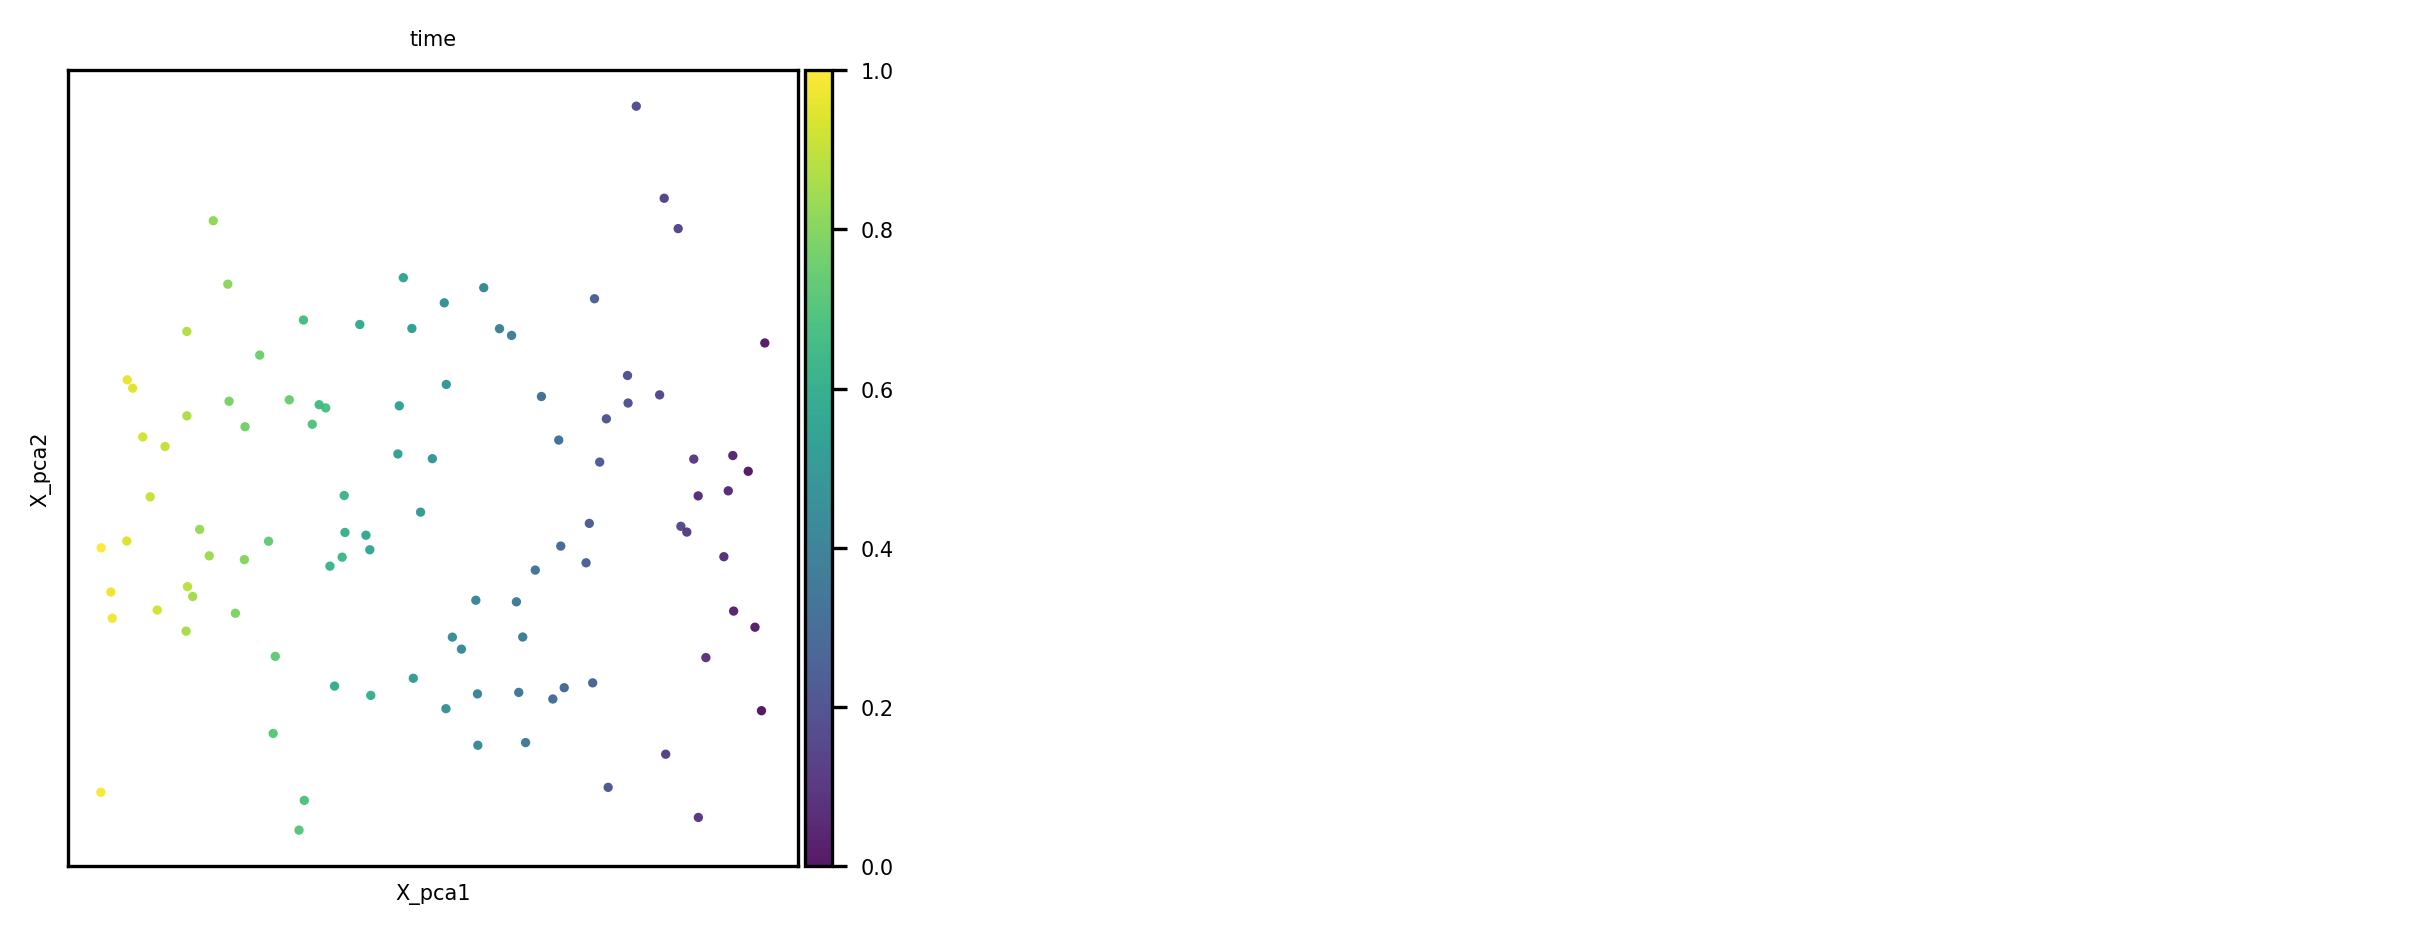

In [9]:
show_basis = 'X_pca'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_ct, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

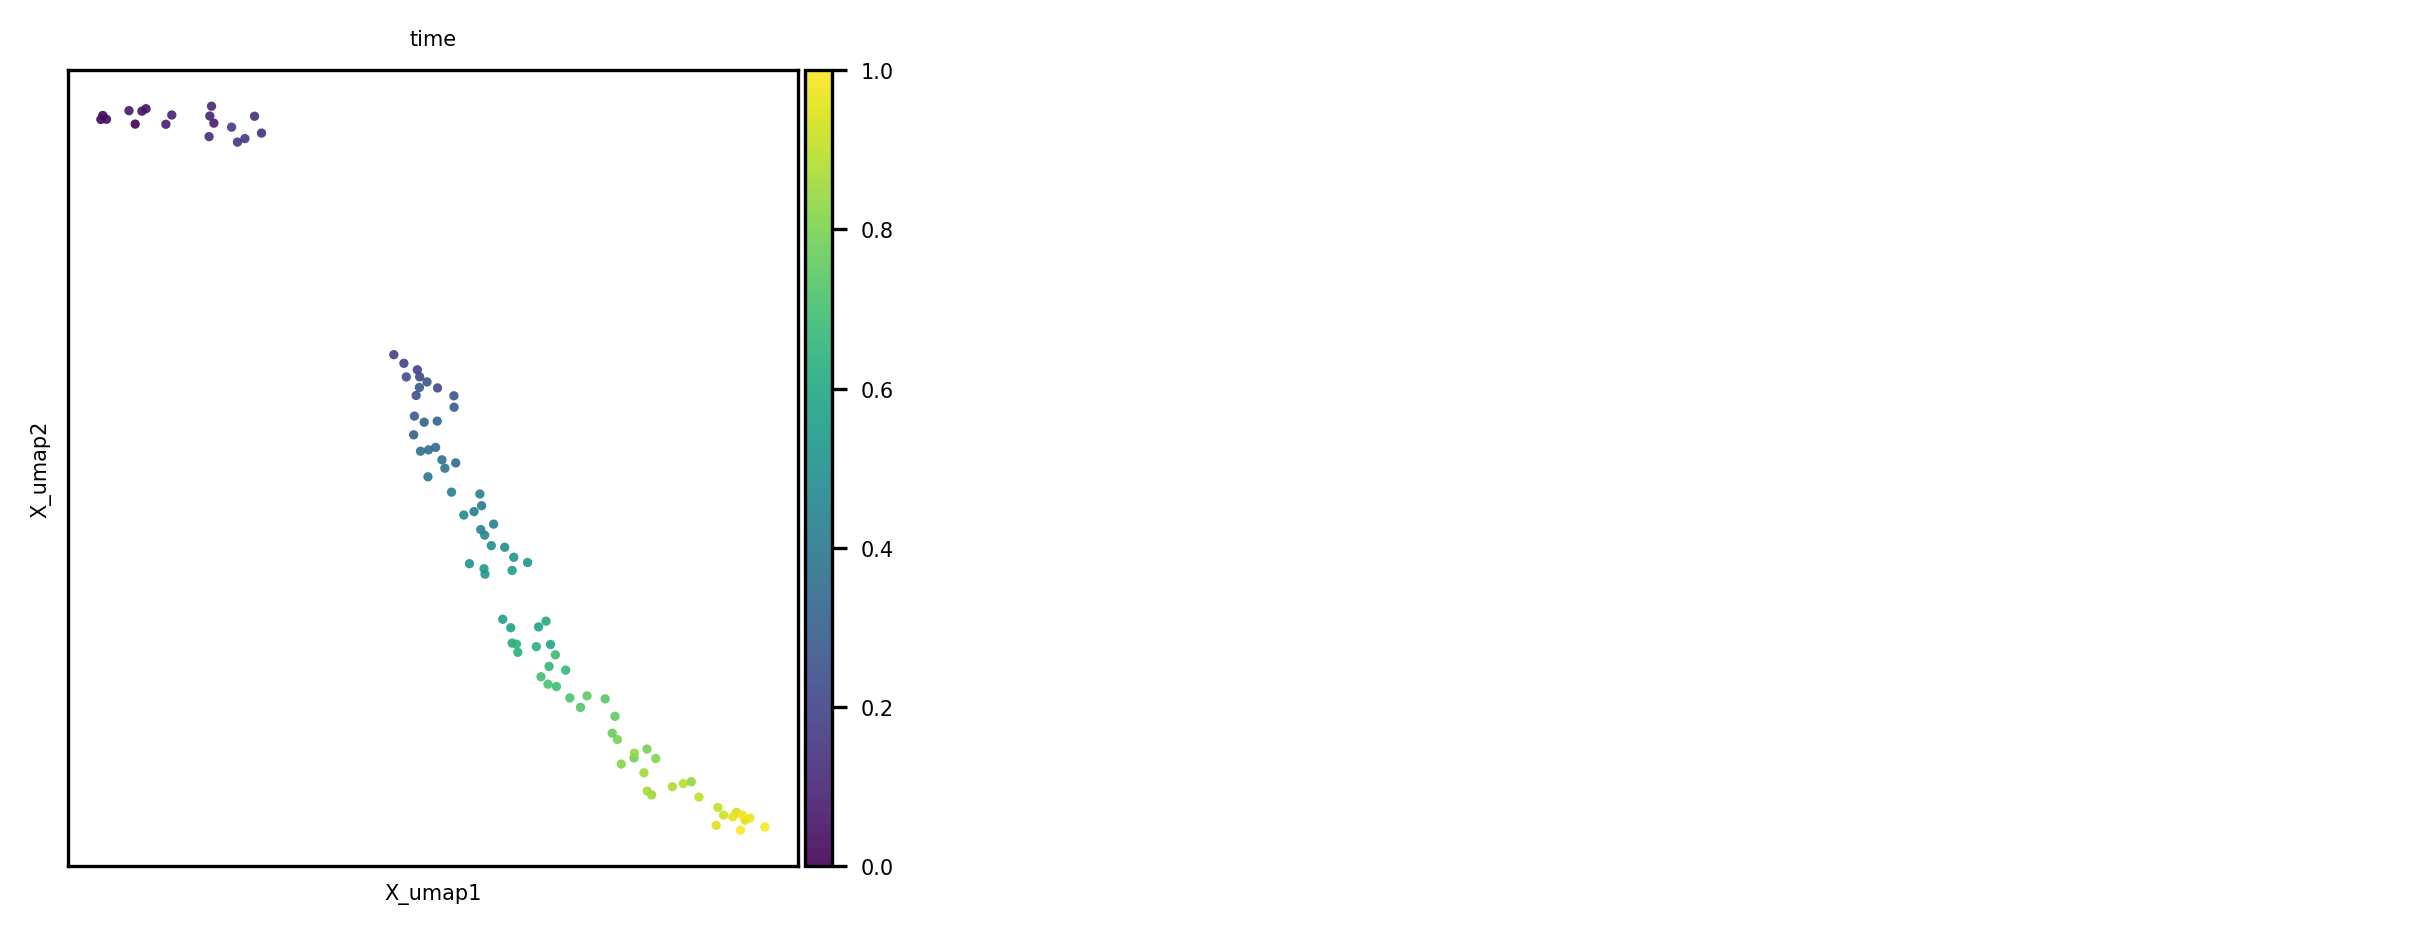

In [10]:
show_basis = 'X_umap'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_ct, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

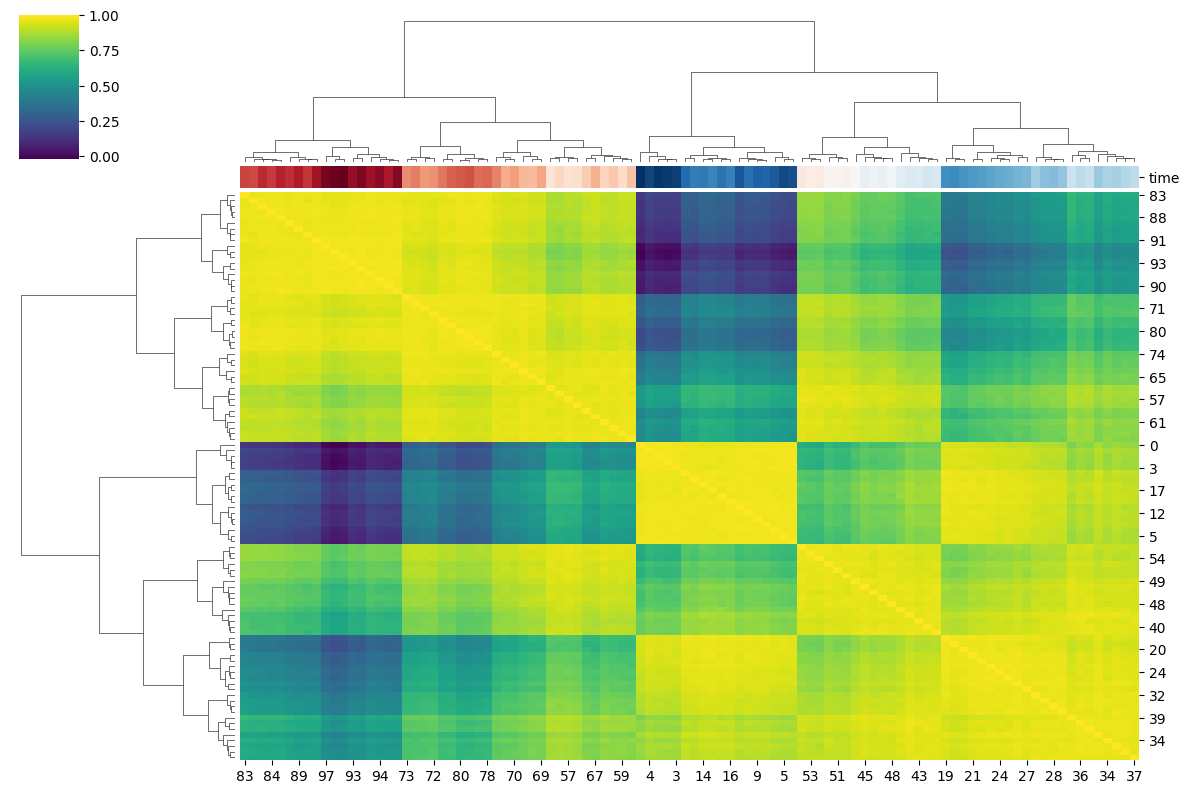

In [11]:
dot_product_matrix = cosine_sim(adata_ct.X)
ccd.pl.heatmap_with_annotations(adata_ct, val=dot_product_matrix, obs_keys=[group_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'nobatch_cosine_sim_heatmap_{file_suffix}.png')

## 0.2 Simulate continuous turning on and off of genes

<Axes: >

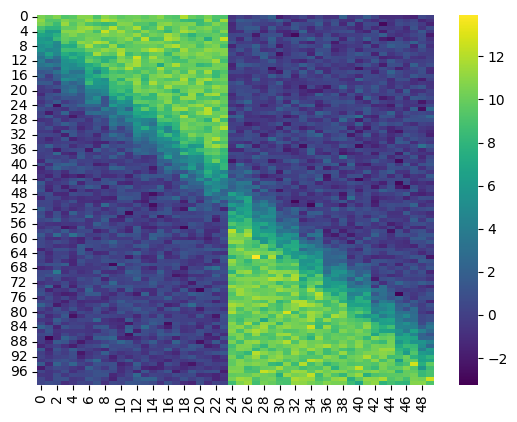

In [133]:
from simulation import simulate_gradual_gene_shift
adata_ct = simulate_gradual_gene_shift(num_genes=ngenes_ct, num_cells=ncells, direction='both', group_size=3, gap_size=5, noise_std=1.0)
sns.heatmap(adata_ct.X, cmap='viridis')


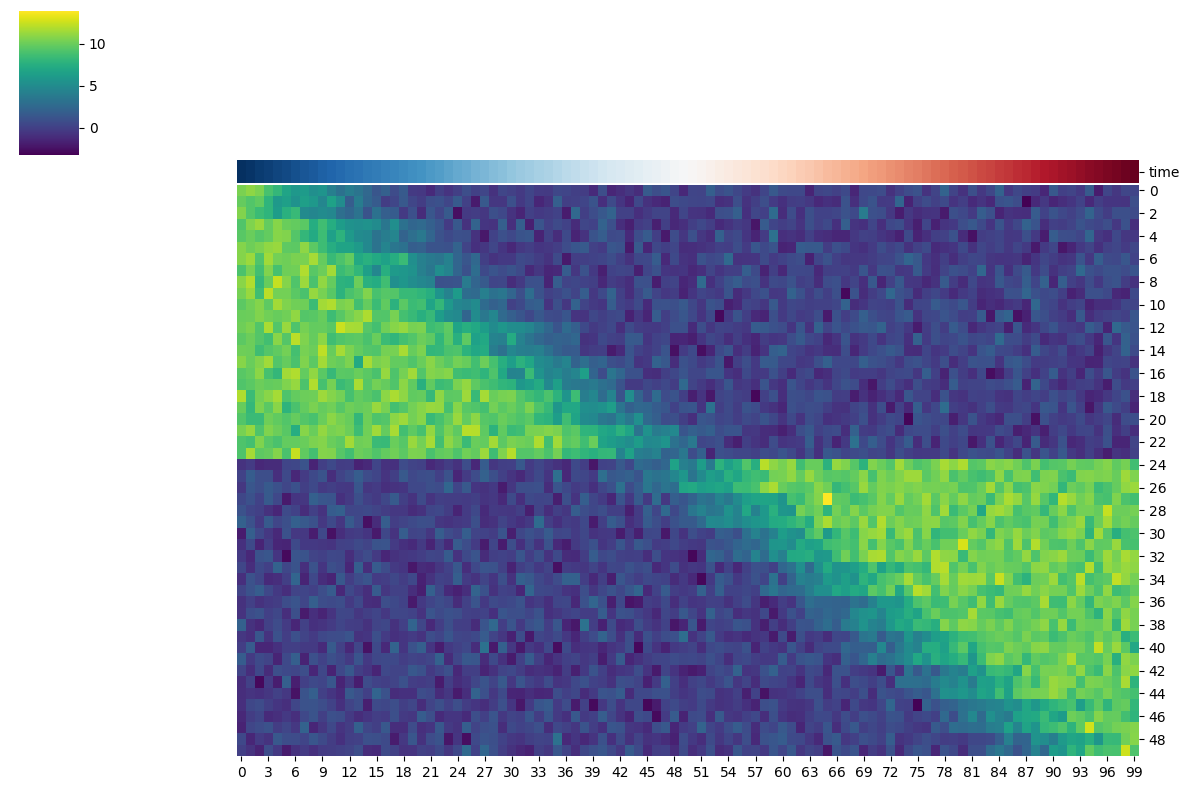

In [134]:
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.pl.heatmap_with_annotations(adata_ct, val='X', obs_keys=[group_key], cluster_cols=False, cluster_rows=False, cmap='viridis', save_path=save_dir/f'ct_heatmap_{file_suffix}.png') 

In [135]:
n_pcs = min(adata_ct.n_obs, adata_ct.n_vars)-1
sc.pp.pca(adata_ct, n_comps=n_pcs)
sc.pp.neighbors(adata_ct, n_neighbors=15, n_pcs=n_pcs)
sc.tl.umap(adata_ct, min_dist=0.1)

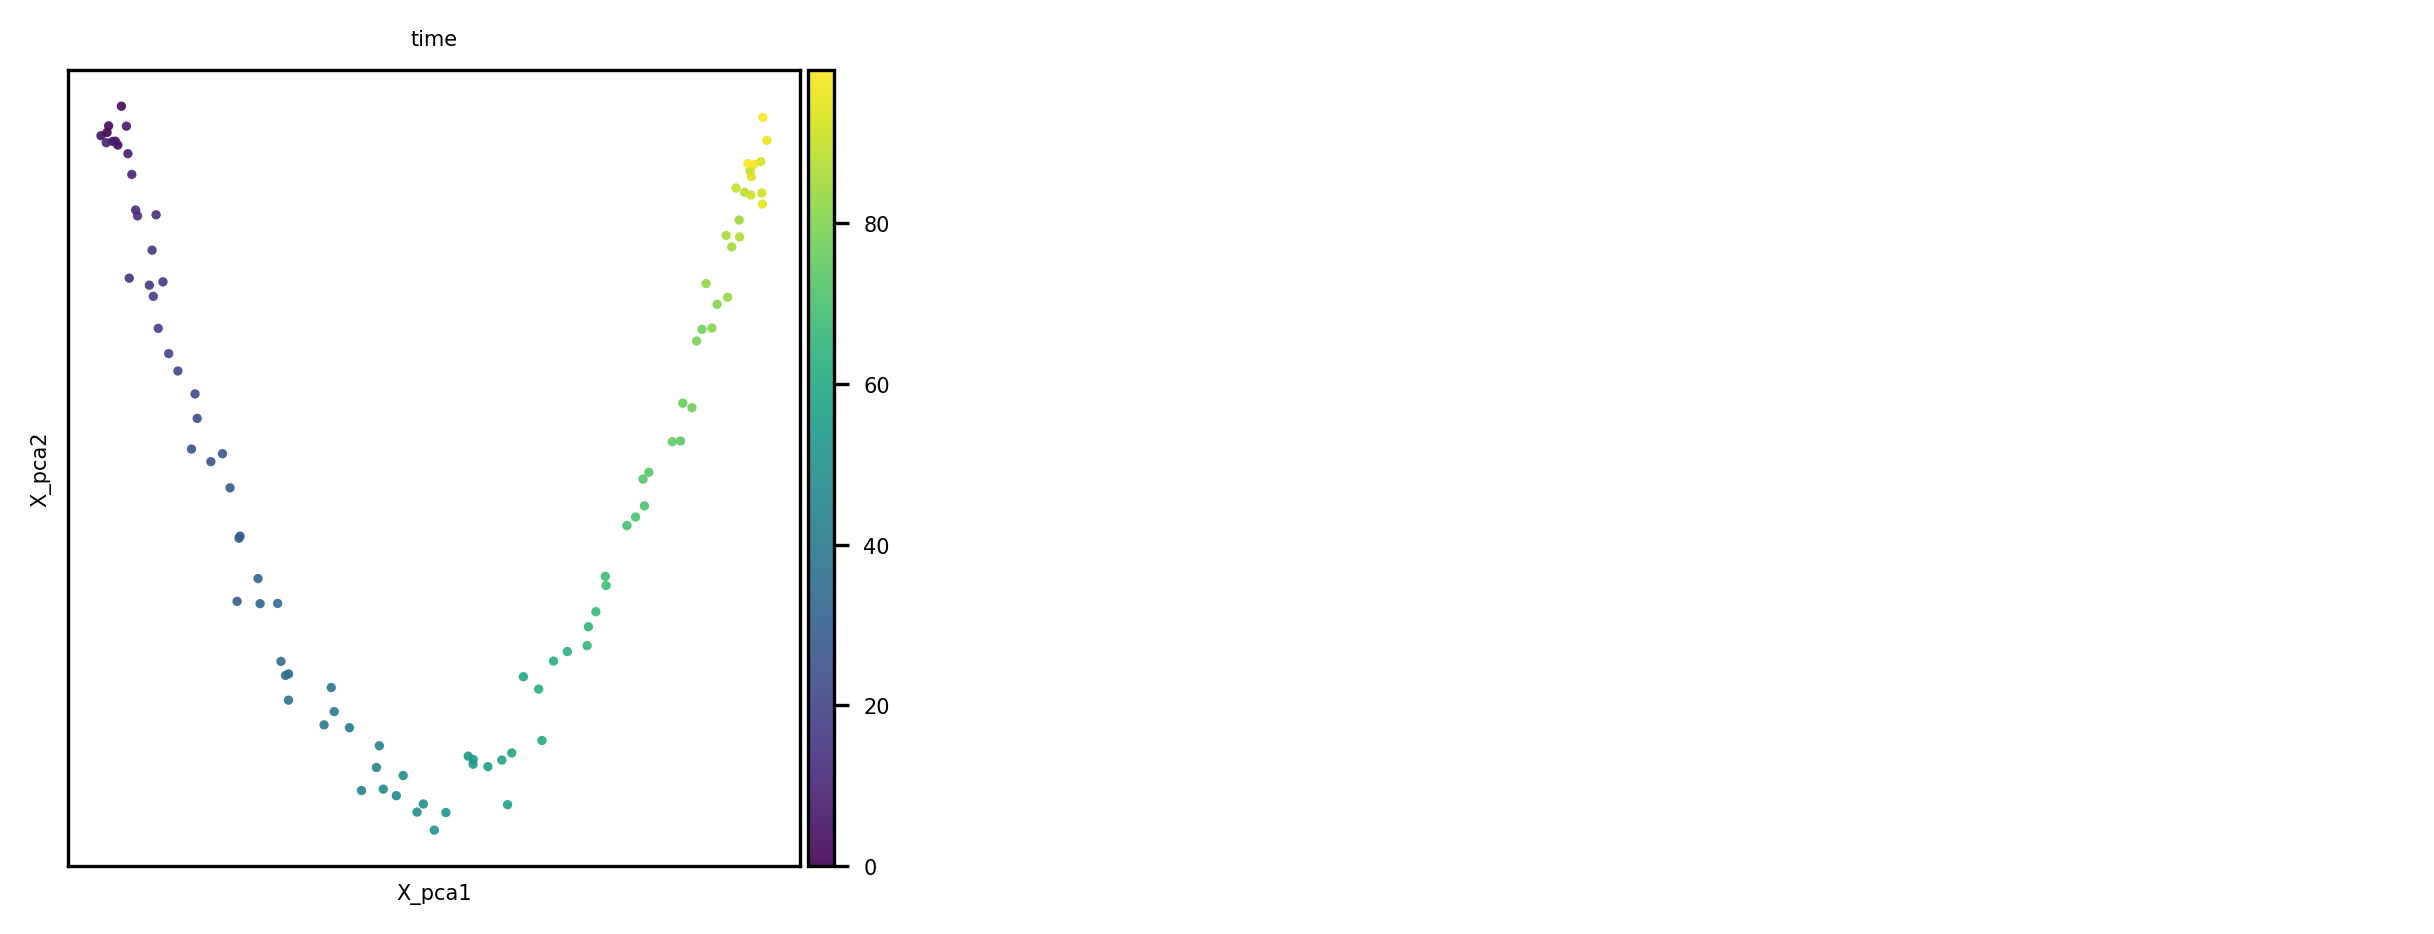

In [136]:
show_basis = 'X_pca'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_ct, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

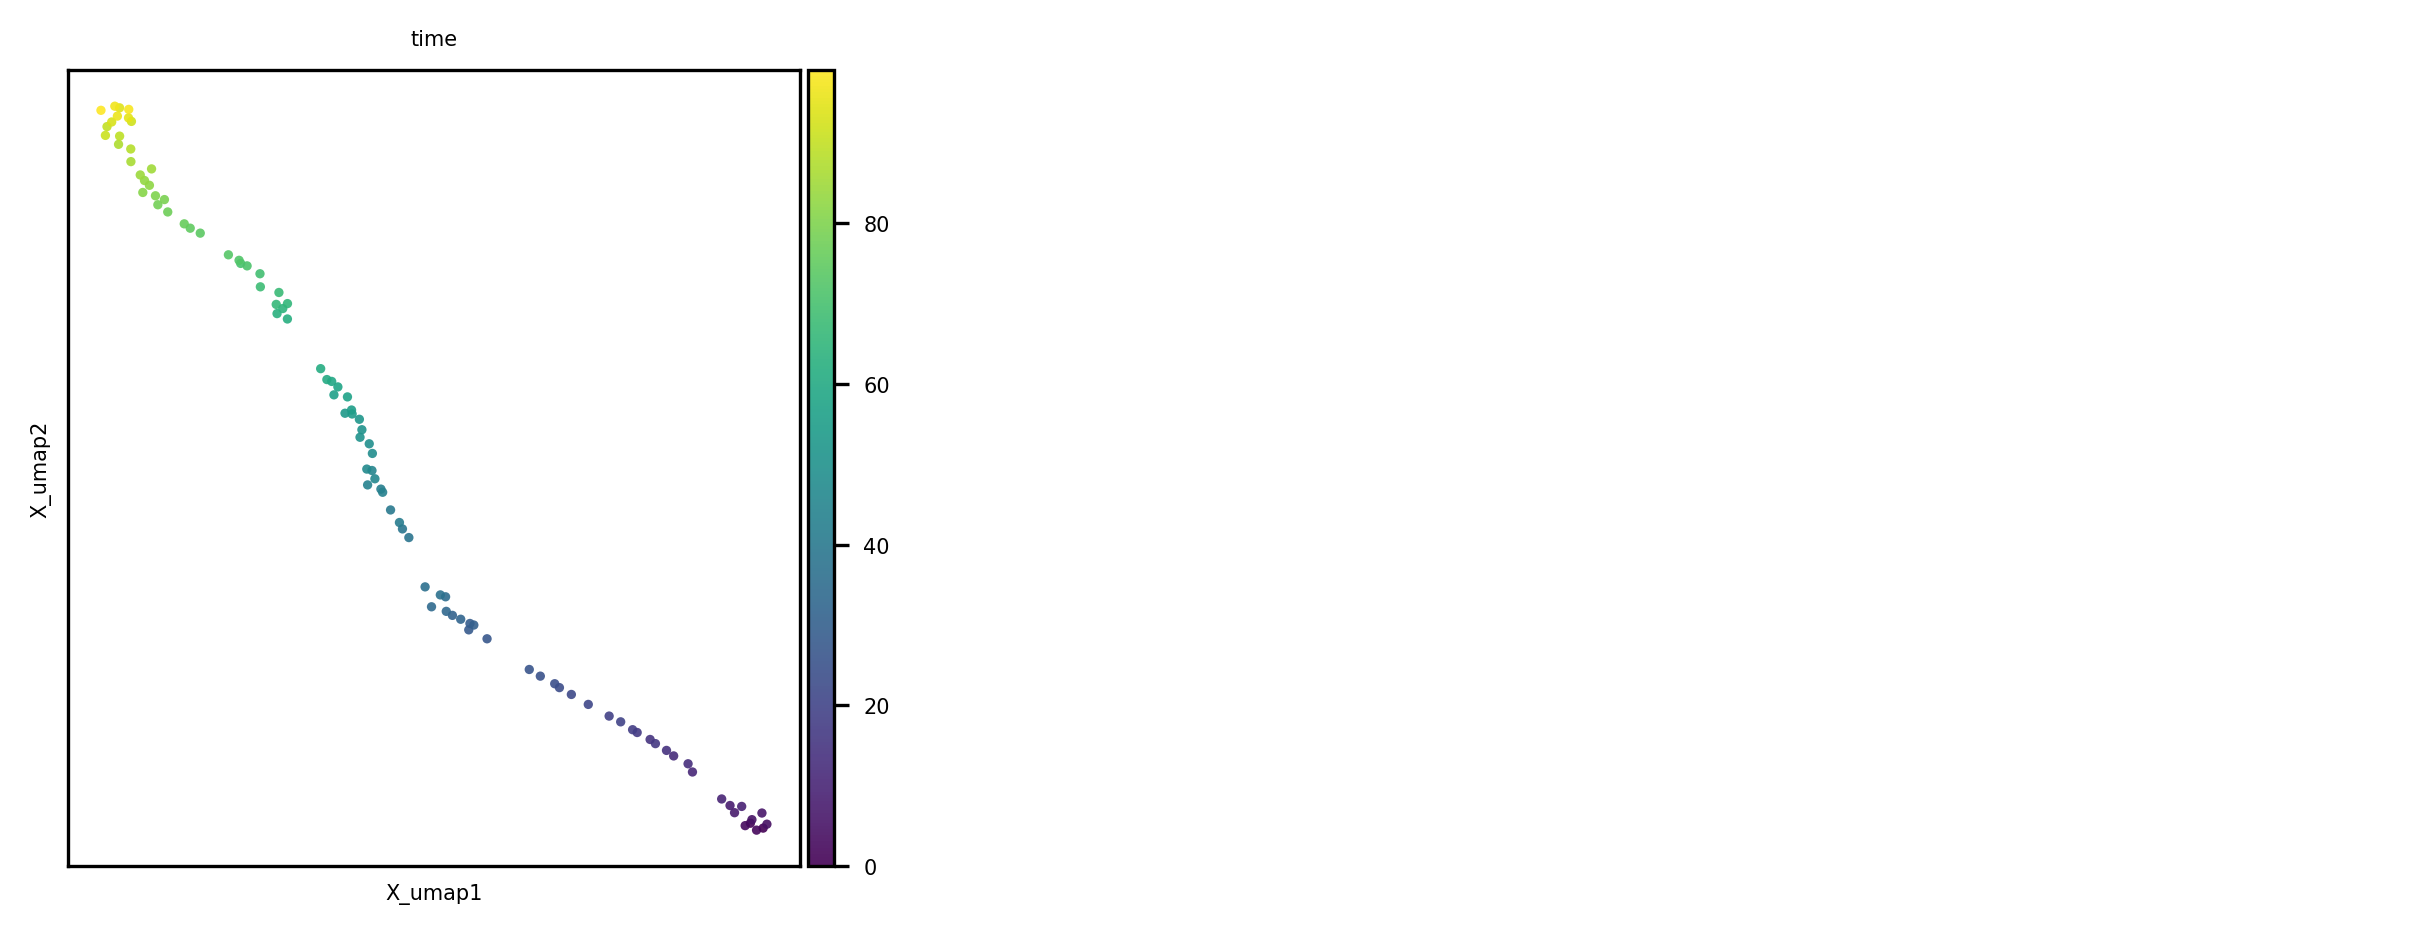

In [123]:
show_basis = 'X_umap'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_ct, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

## Simulate batch effect 

### Approach 1:  simulate batch specific structure and concatenate or add to existing matrix

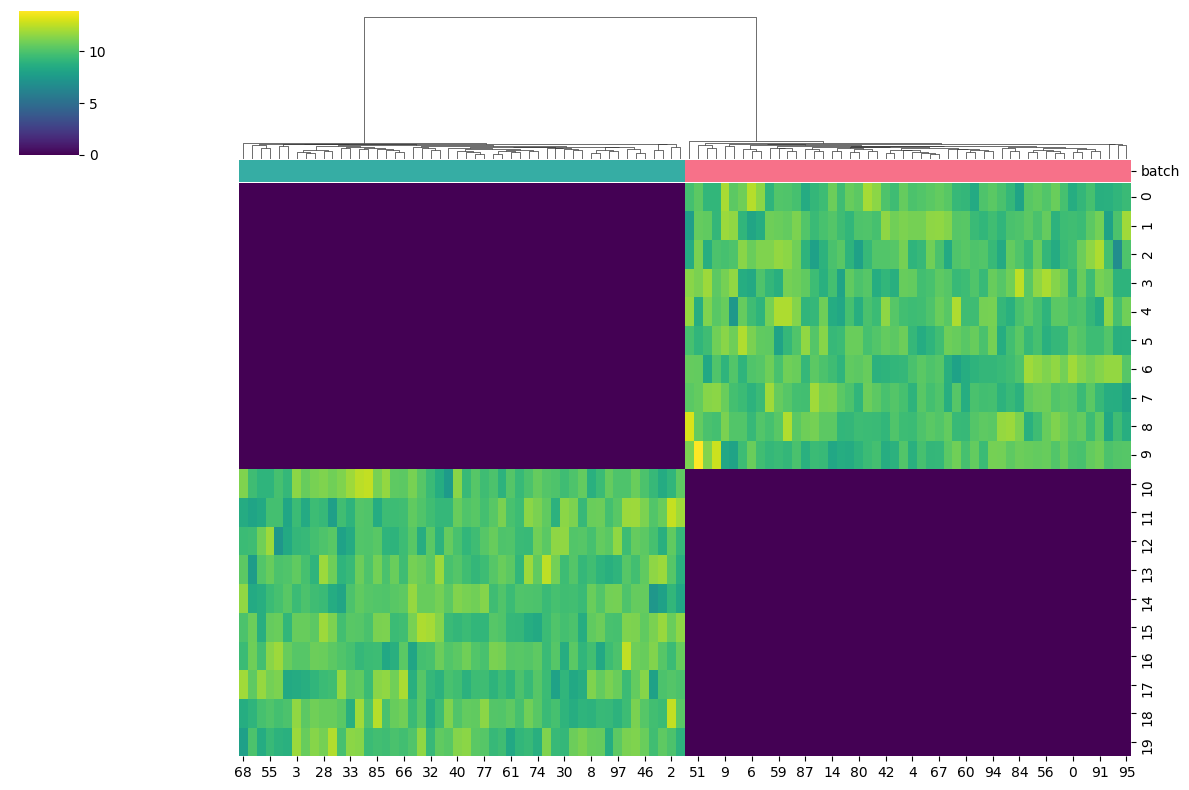

In [19]:
batch_key = 'batch'
ngenes_dm=20
adata_batch = simulate_expression_data_groups(num_genes=ngenes_dm, num_cells=ncells, num_groups=2, mean_expression=10, noise_std=1.0, 
                                        p_gene_nonspecific=0.0, group_key=batch_key,permute=True, seed=42)
ccd.pl.heatmap_with_annotations(adata_batch, val='X', obs_keys=[batch_key], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'batch_heatmap_{file_suffix}.png') 

#### 1.1 Concatenate mode

In [21]:
# Example usage
batch_mode = 'concatenate'
adata = combine_adatas_by_gene_dimension(
    adata_ct, adata_batch
)

# Check the structure of the combined AnnData
adata.obs


,time,batch
cell_0,0.000000,batch_1
cell_1,0.010101,batch_2
cell_2,0.020202,batch_2
cell_3,0.030303,batch_2
cell_4,0.040404,batch_1
...,...,...
cell_95,0.959596,batch_1
cell_96,0.969697,batch_2
cell_97,0.979798,batch_2
cell_98,0.989899,batch_2


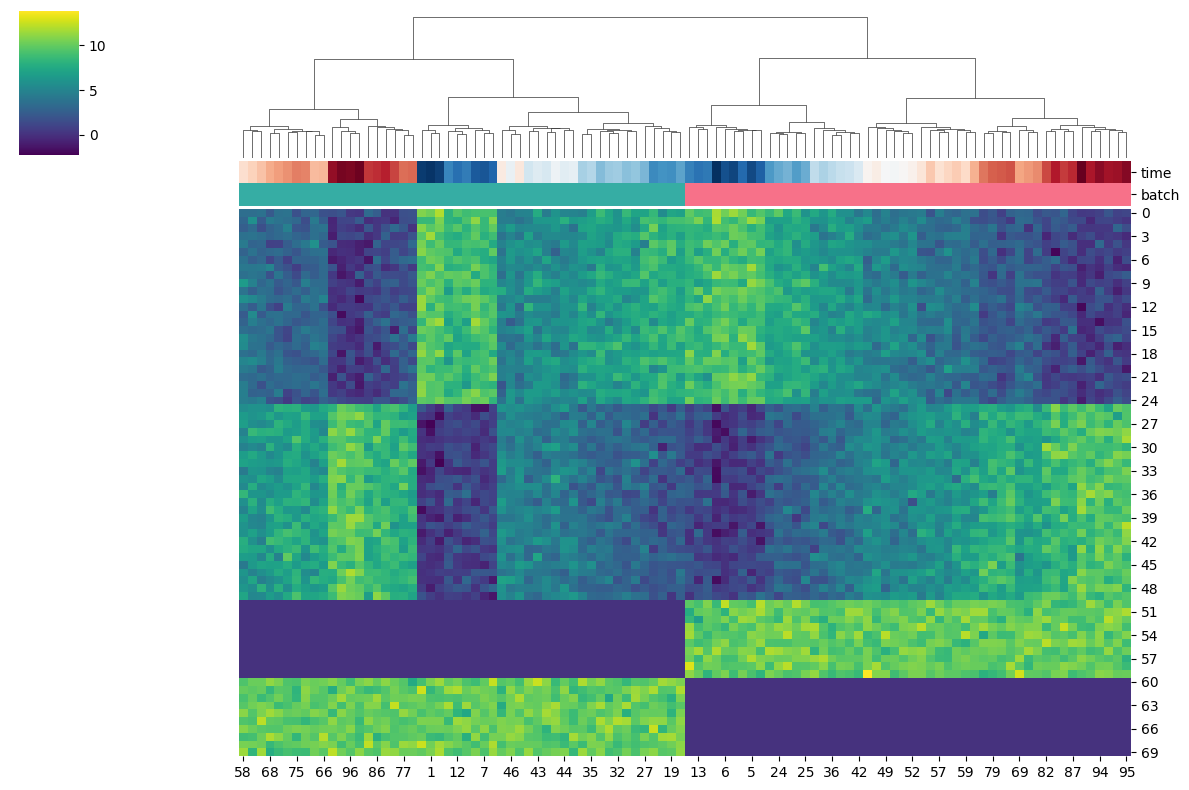

In [22]:
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png') 

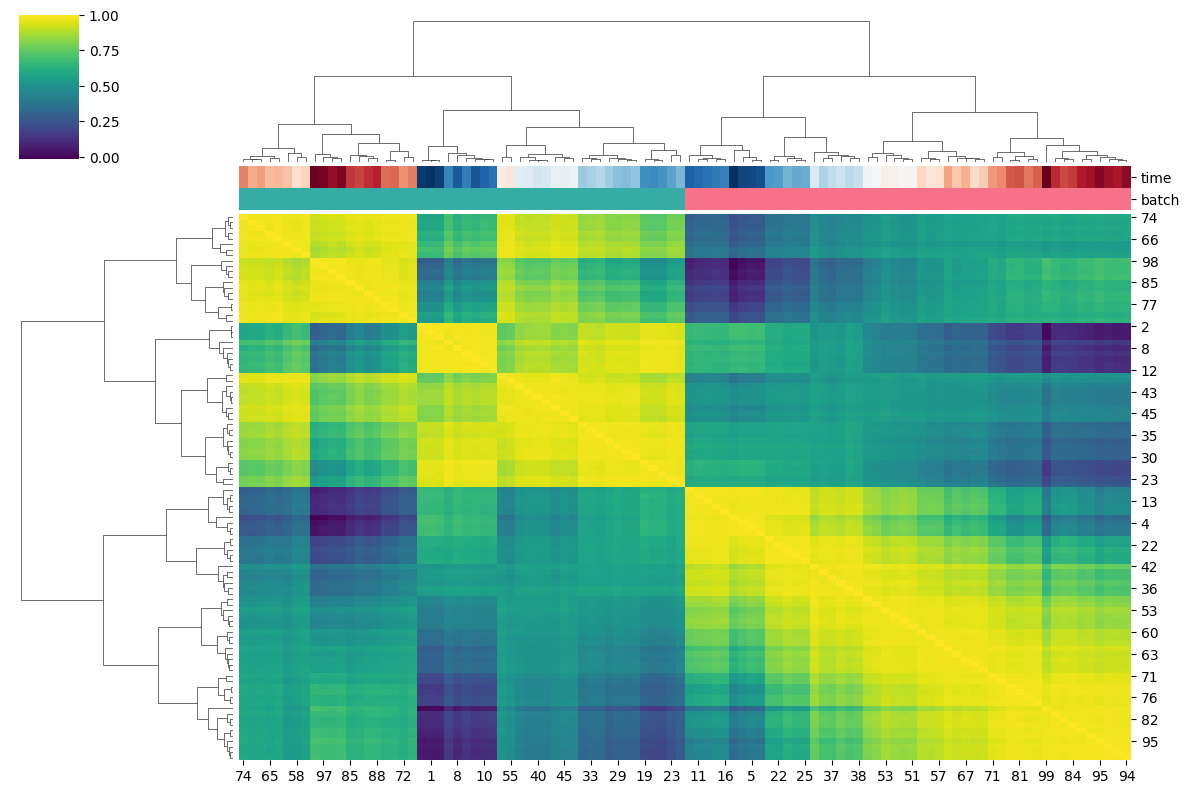

In [23]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

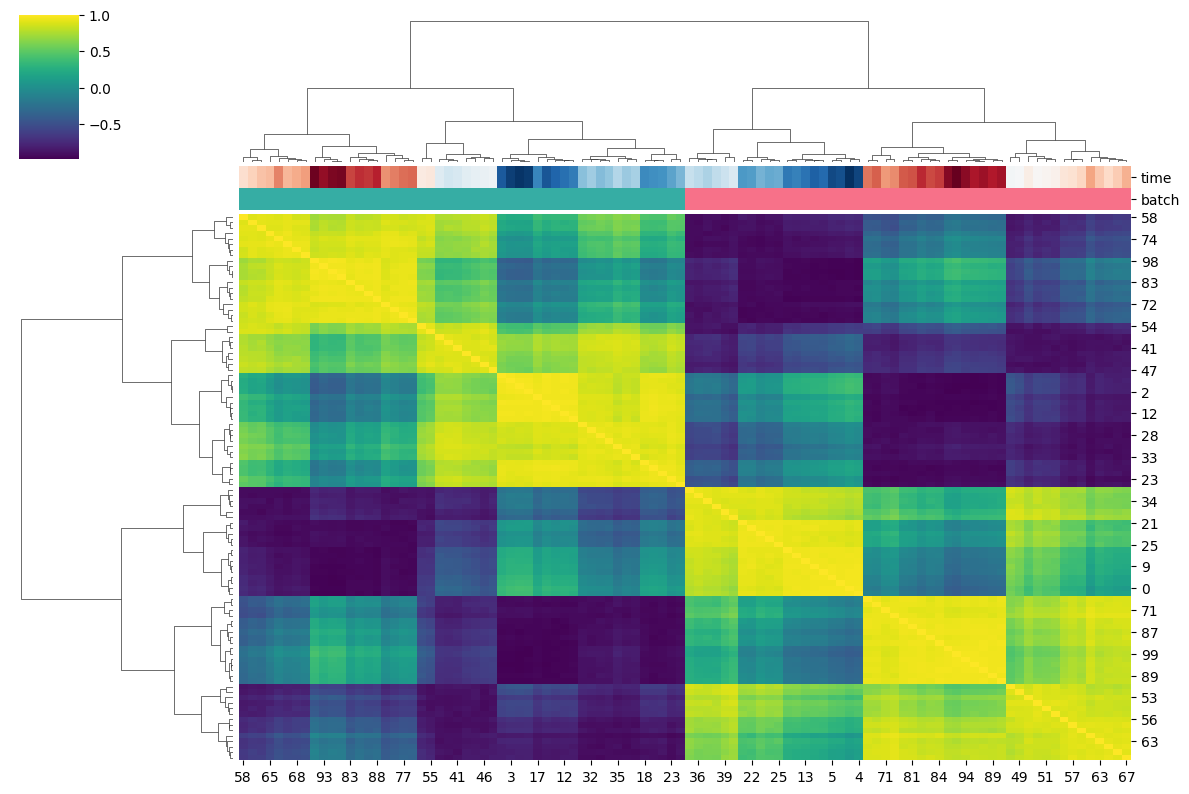

In [24]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 1.2 Add mode

In [760]:
import numpy as np
import pandas as pd
import anndata as ad

def add_adatas_to_random_features(adata1, adata2, reindex_cells=True, seed=42):
    """
    Adds the expression values from adata2 to randomly selected features in adata1.

    Parameters:
    - adata1: AnnData object to which the values from adata2 will be added.
    - adata2: AnnData object whose values will be added to adata1.
    - reindex_cells: If True, reindex cell names to match between adata1 and adata2.
    - seed: Random seed for reproducibility.

    Returns:
    - combined_adata: AnnData object with the modified expression matrix and updated metadata.
    """
    np.random.seed(seed)
    
    if reindex_cells:
        # Reindex the cells to match cell names
        adata1.obs_names = [f"cell_{i}" for i in range(adata1.n_obs)]
        adata2.obs_names = [f"cell_{i}" for i in range(adata2.n_obs)]
    else:
        assert np.all(adata1.obs_names == adata2.obs_names), "Cell names must be the same in both AnnData objects."
    
    # Ensure that adata2 has the same number of observations (cells) as adata1
    assert adata1.n_obs == adata2.n_obs, "Both AnnData objects must have the same number of cells."
    
    # Randomly select features (genes) from adata1 to add the values from adata2
    selected_genes = np.random.choice(adata1.var_names, size=adata2.n_vars, replace=False)
    
    # Create a copy of adata1's X to modify
    combined_X = adata1.X.copy()
    
    # Add adata2's expression values to the randomly selected features in adata1
    for i, gene in enumerate(selected_genes):
        combined_X[:, adata1.var_names.get_loc(gene)] += adata2.X[:, i]
    
    # Update the observation metadata (obs)
    combined_obs = adata1.obs.copy()
    combined_obs = pd.concat([combined_obs, adata2.obs], axis=1)
    
    # Keep the same variable metadata (var) from adata1
    combined_var = adata1.var.copy()
    
    # Create the combined AnnData object
    combined_adata = ad.AnnData(X=combined_X, obs=combined_obs, var=combined_var)
    
    return combined_adata



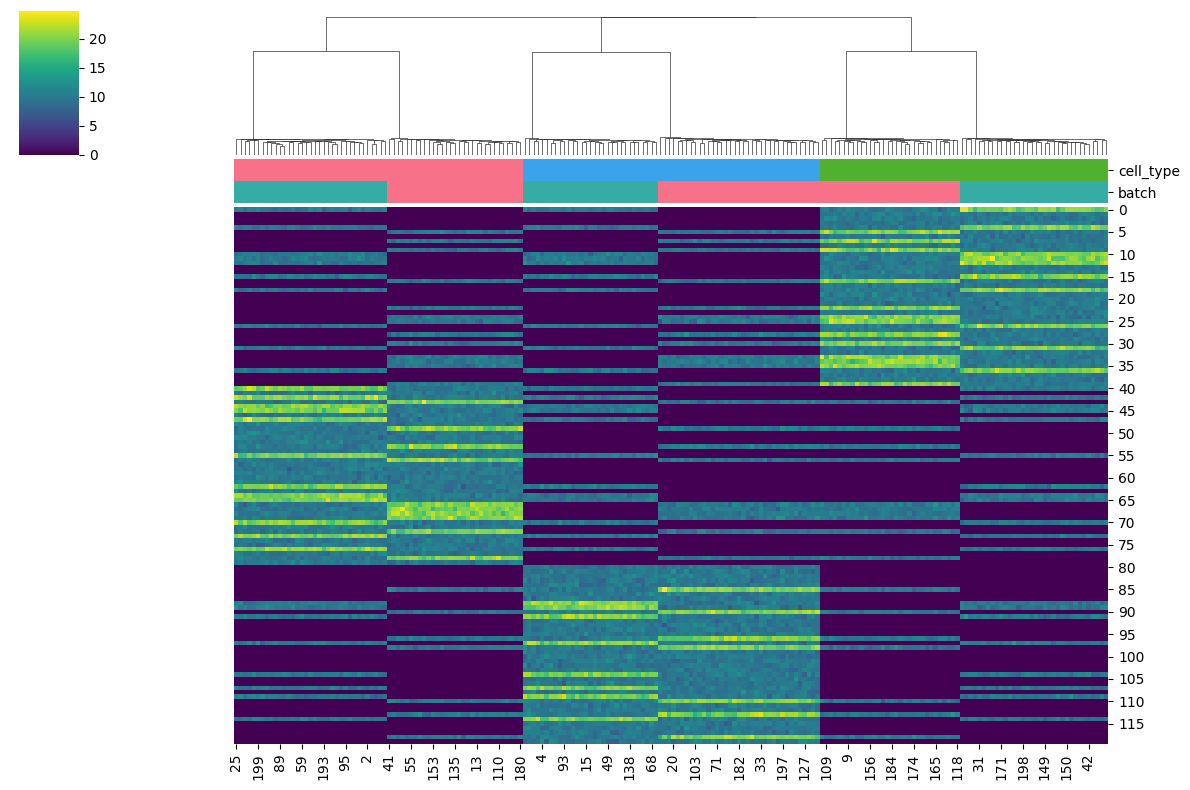

In [767]:
batch_mode = 'random_add'
adata = add_adatas_to_random_features(adata_ct, adata_batch, reindex_cells=True, seed=42)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')

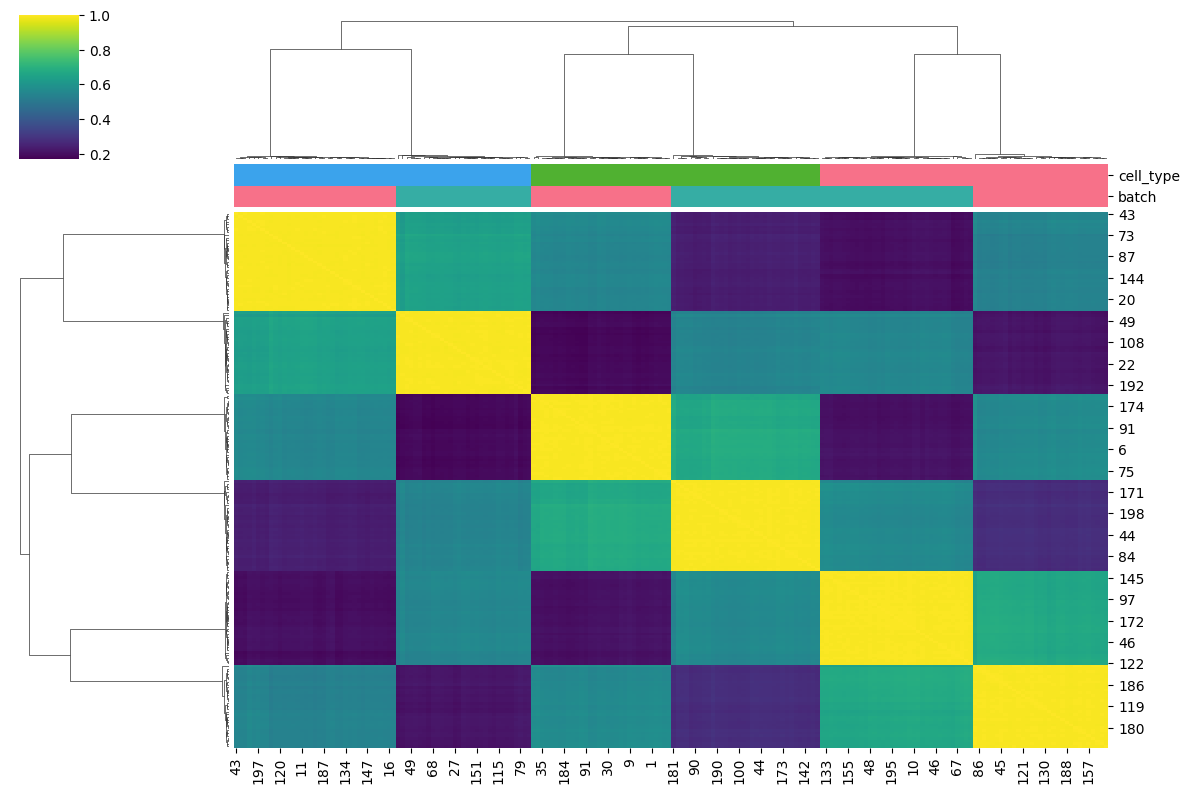

In [762]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png') 

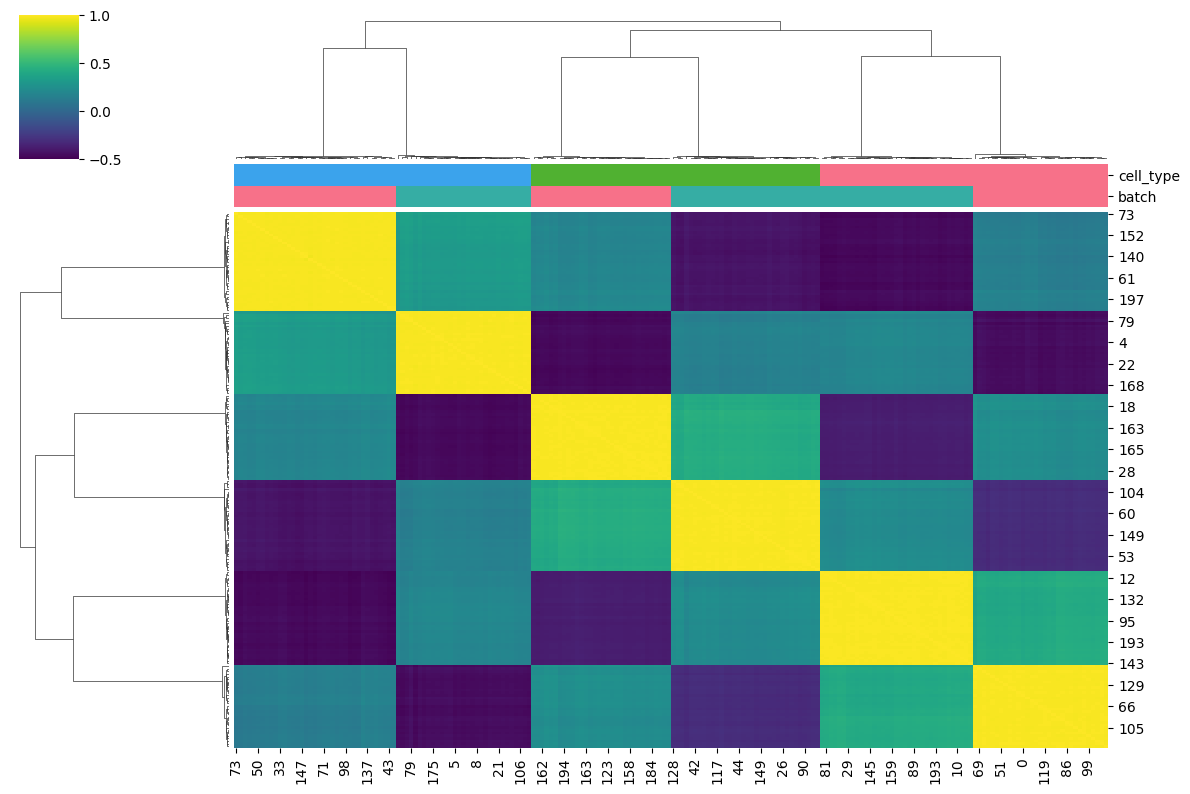

In [763]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

### Approach 2: Simulate batch based on the matrix

In [777]:
import numpy as np
import anndata as ad
import scipy.sparse as sp

def simulate_batch(
    adata: ad.AnnData,
    effect_type: str = 'mean_shift',
    effect_strength: float = 1.0,
    cell_proportion: float = 0.3,
    batch_name: str = 'batch_1',
    seed: int = 42
) -> ad.AnnData:
    np.random.seed(seed)

    if not (0 < cell_proportion <= 1):
        raise ValueError("cell_proportion must be between 0 and 1.")

    # Determine the number of cells to sample
    n_cells = int(adata.n_obs * cell_proportion)
    
    # Randomly sample cells without replacement
    cell_indices = np.random.choice(adata.n_obs, size=n_cells, replace=False)
    
    # Create a subset AnnData object
    batch_adata = adata[cell_indices].copy()
    
    # Assign batch name
    batch_adata.obs['batch'] = batch_name

    # Apply the specified batch effect
    if effect_type == 'mean_shift':
        # Shift the mean expression
        shift_vector = np.random.normal(loc=effect_strength, scale=0.1, size=batch_adata.n_vars)
        if sp.issparse(batch_adata.X):
            # For sparse matrix, add shift_vector to each row
            batch_adata.X = batch_adata.X + shift_vector
        else:
            batch_adata.X += shift_vector
    elif effect_type == 'variance_inflation':
        # Inflate the variance
        scale_vector = 1 + np.random.normal(loc=0, scale=effect_strength, size=batch_adata.n_vars * batch_adata.n_obs).reshape(batch_adata.n_obs, batch_adata.n_vars)
        if sp.issparse(batch_adata.X):
            batch_adata.X = batch_adata.X.toarray()
            batch_adata.X *= scale_vector
            batch_adata.X = sp.csr_matrix(batch_adata.X)
        else:
            batch_adata.X *= scale_vector
    elif effect_type == 'dropout_increase':
        # Increase the dropout rate
        dropout_prob = effect_strength
        dropout_mask = np.random.rand(batch_adata.n_obs, batch_adata.n_vars) < dropout_prob
        if sp.issparse(batch_adata.X):
            batch_adata.X = batch_adata.X.toarray()
            batch_adata.X[dropout_mask] = 0
            batch_adata.X = sp.csr_matrix(batch_adata.X)
        else:
            batch_adata.X[dropout_mask] = 0
    elif effect_type == 'scaling_factor':
        # Apply a scaling factor
        scaling_vector = effect_strength
        if sp.issparse(batch_adata.X):
            scaling_matrix = sp.diags(scaling_vector)
            batch_adata.X = batch_adata.X @ scaling_matrix
        else:
            batch_adata.X *= scaling_vector
    else:
        raise ValueError(f"Unknown effect_type '{effect_type}'. Choose from 'mean_shift', 'variance_inflation', 'dropout_increase', or 'scaling_factor'.")

    return batch_adata


#### 2.1 Dropout mode

In [778]:
batch_mode = 'dropout_increase'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=0.0,
    cell_proportion=0.5,
    batch_name='b1_nodropout',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=.5,
    cell_proportion=0.5,
    batch_name='b2_dropout',
    seed=43
)

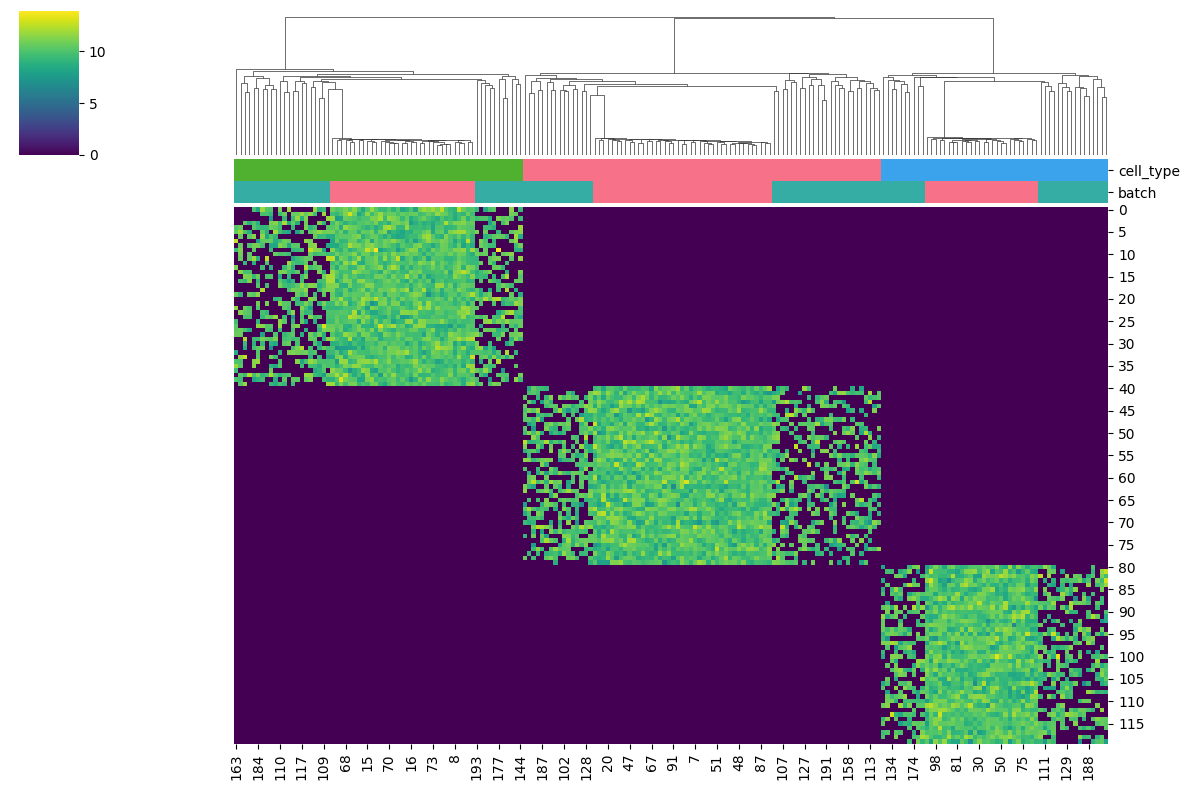

In [779]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')


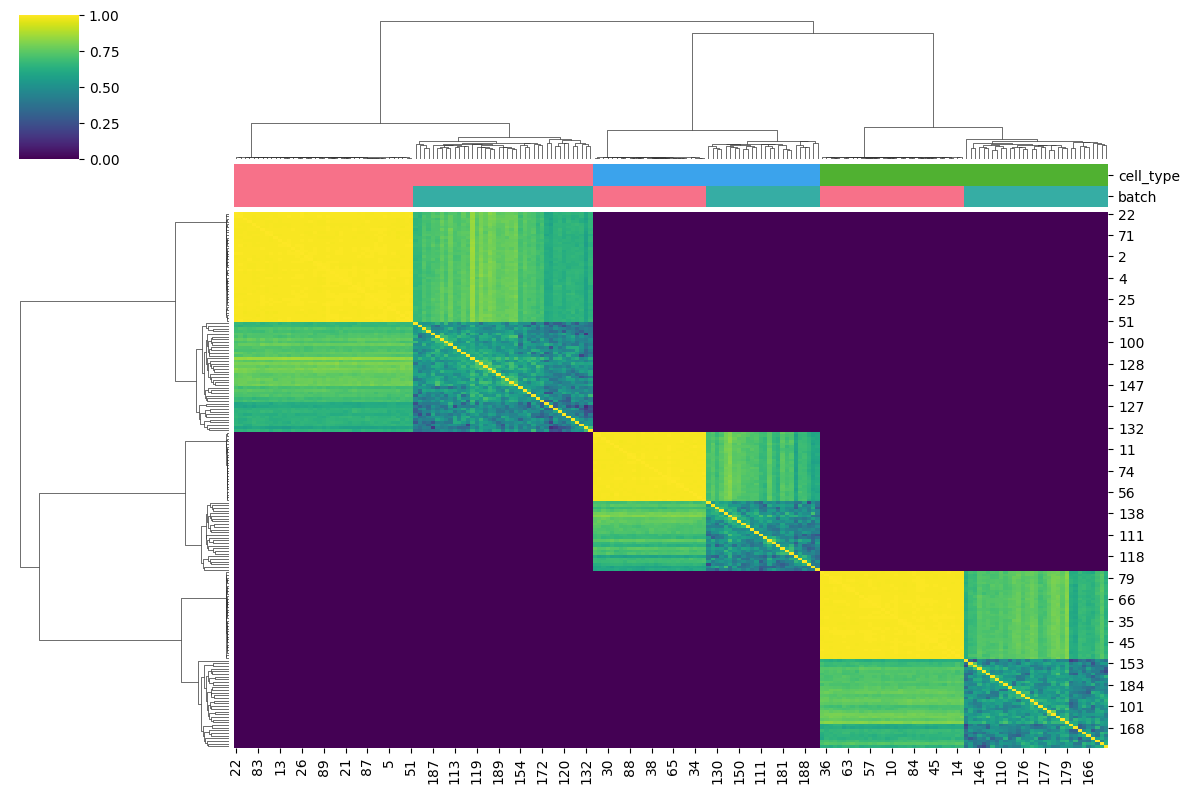

In [780]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

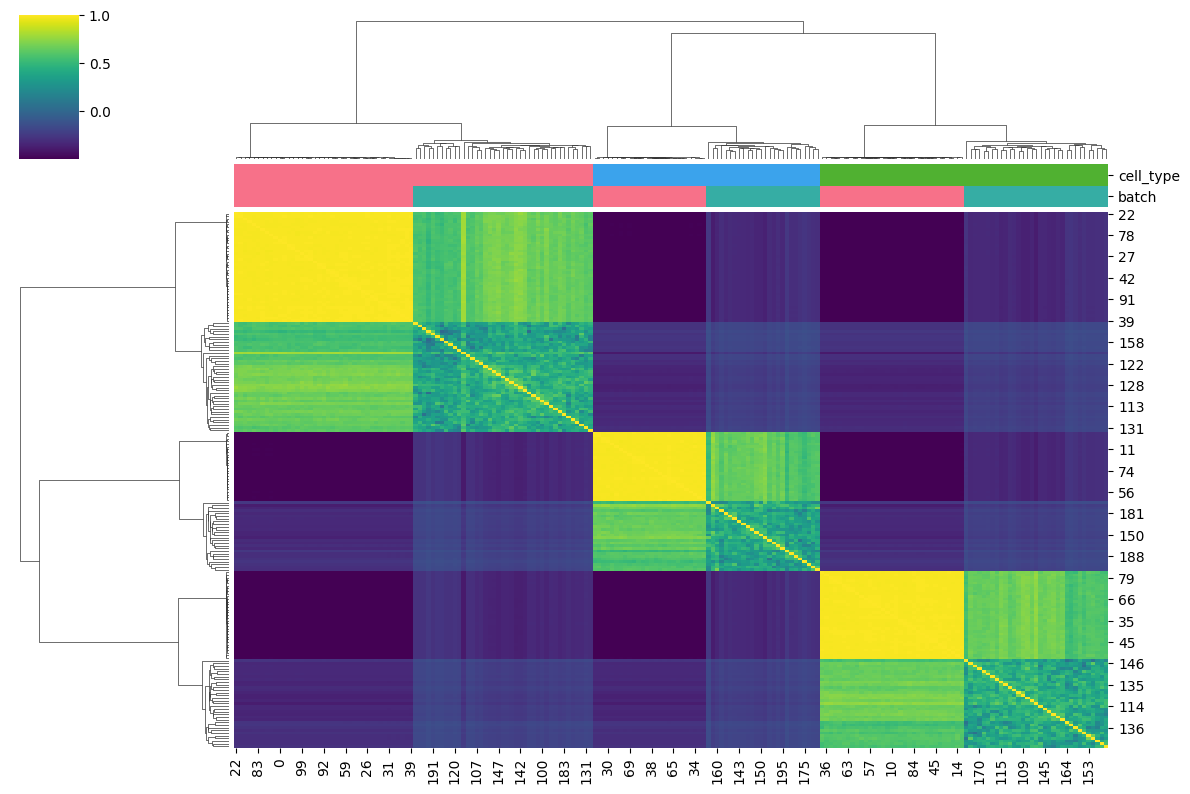

In [781]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 2.2 Scale mode

In [791]:
batch_mode = 'scaling_factor'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=1.0,
    cell_proportion=0.5,
    batch_name='b1_noscale',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=3.0,
    cell_proportion=0.5,
    batch_name='b2_scale',
    seed=43
)

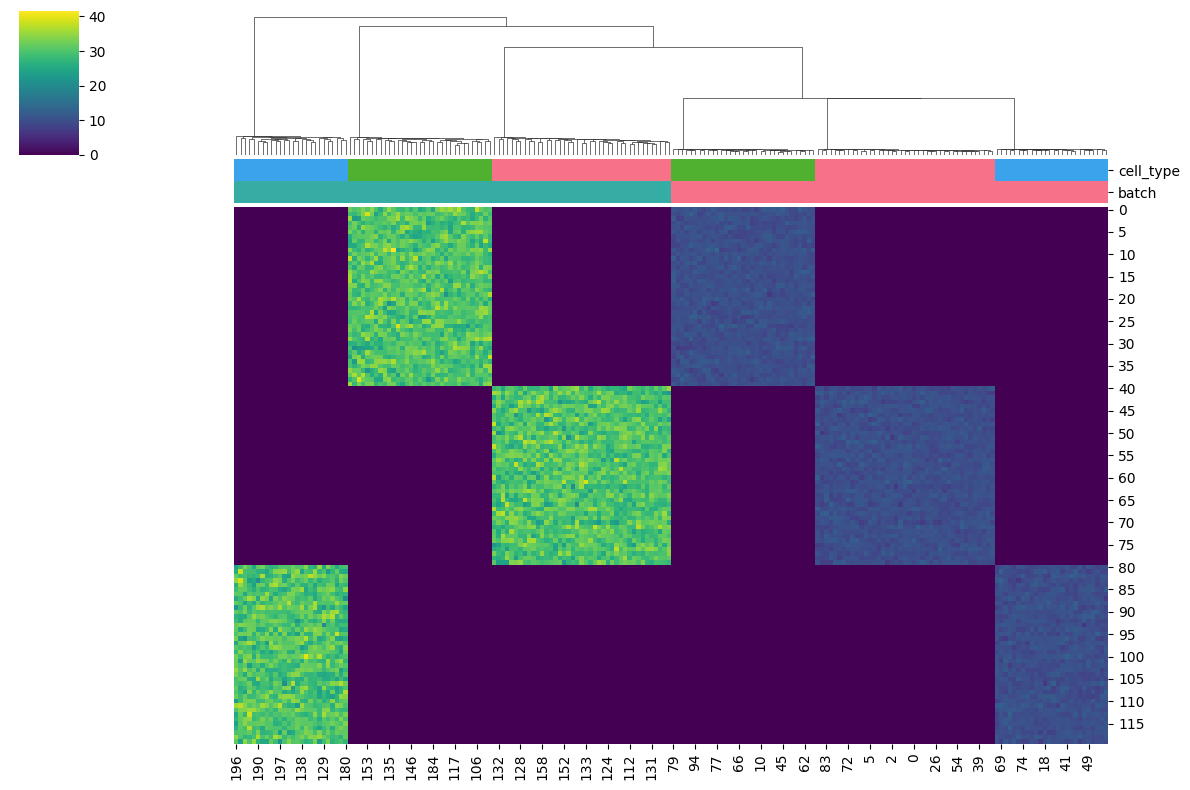

In [792]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')


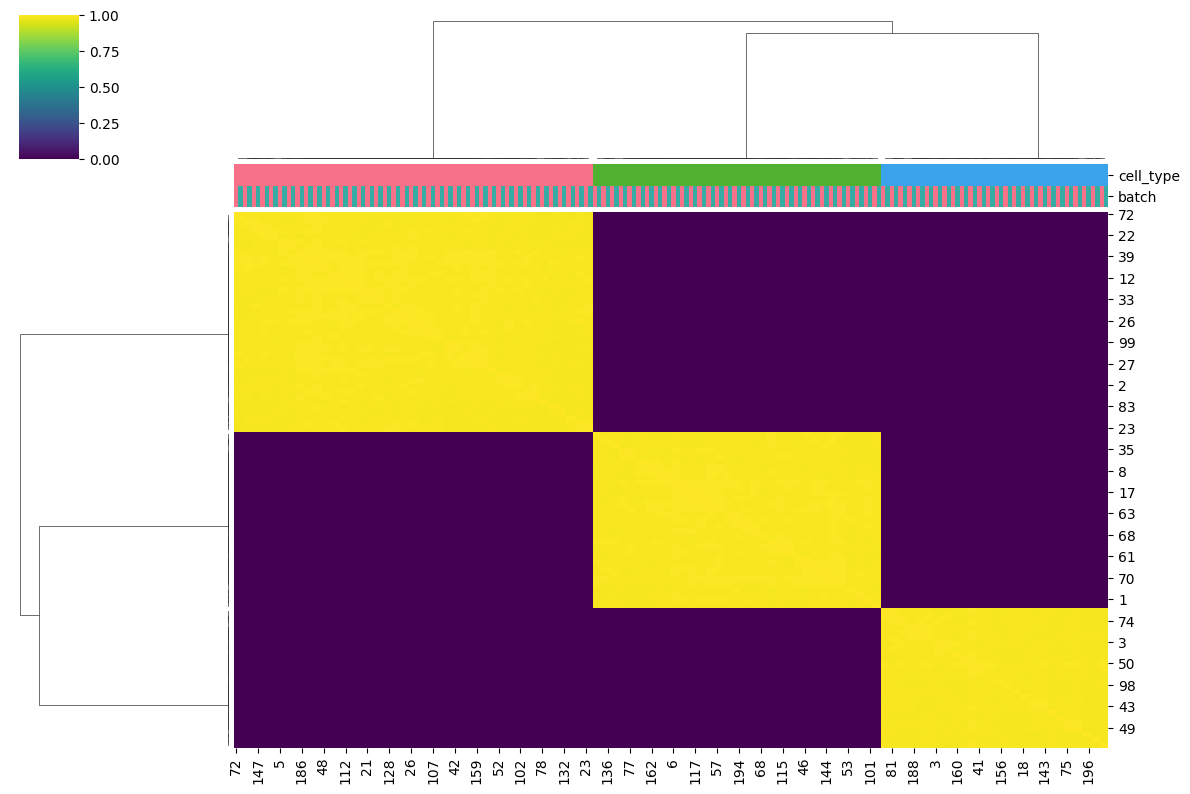

In [793]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

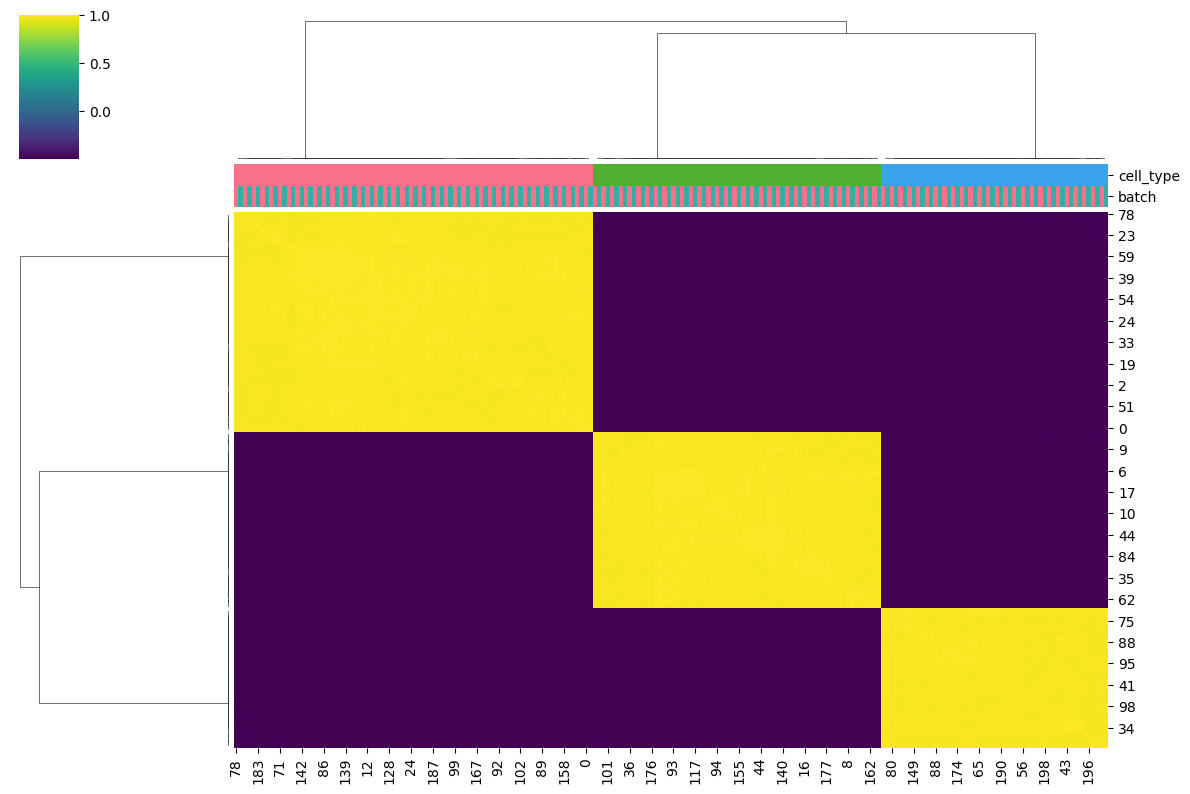

In [794]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 2.3 Variance inflation mode

In [804]:
batch_mode = 'variance_inflation'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=0.0,
    cell_proportion=0.5,
    batch_name='b1_nodropout',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=1.0,
    cell_proportion=0.5,
    batch_name='b2_dropout',
    seed=43
)

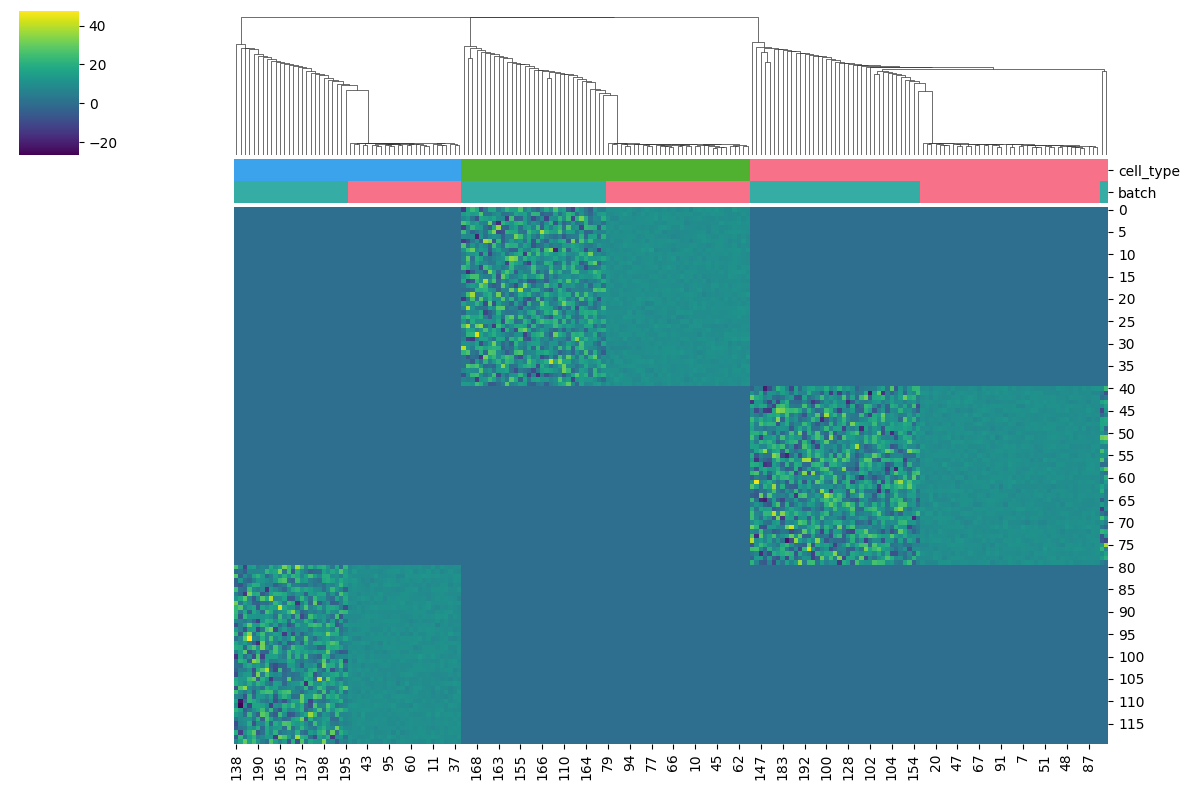

In [805]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png') 


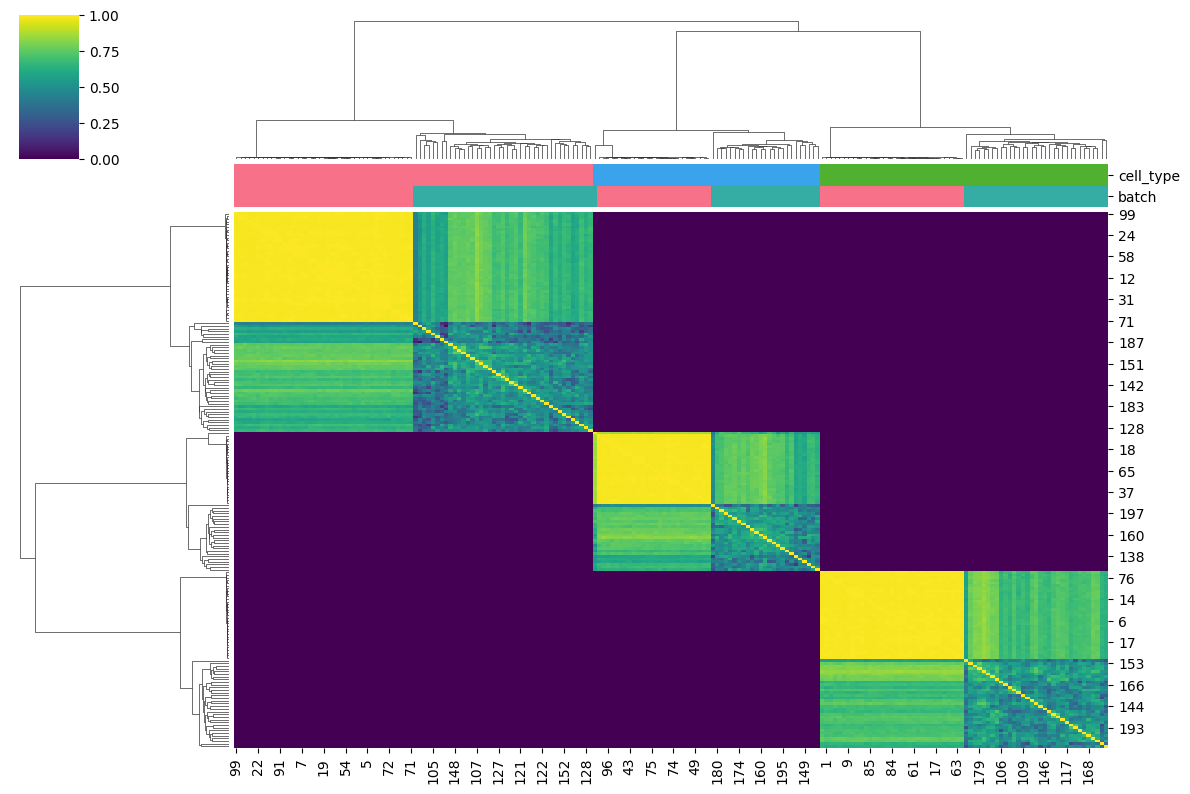

In [806]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

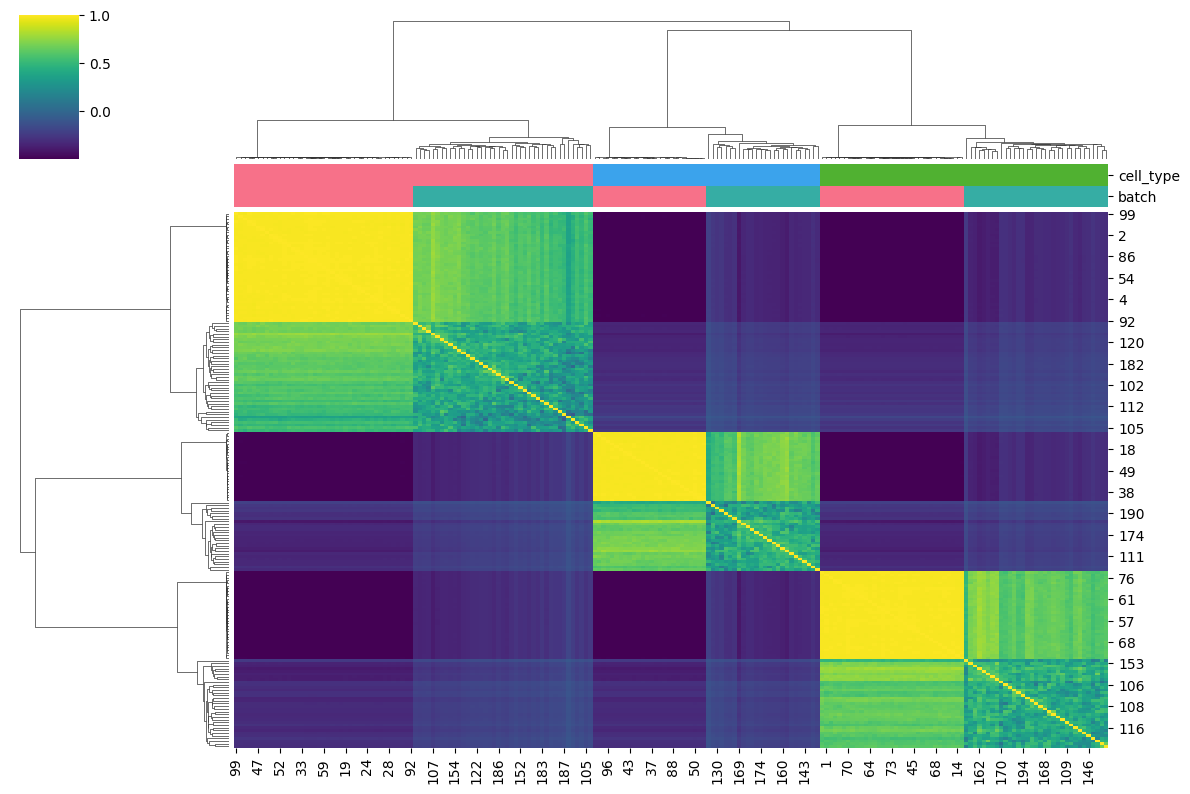

In [807]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 2.4 Mean shift global

In [817]:
batch_mode = 'mean_shift'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=0.0,
    cell_proportion=0.5,
    batch_name='b1_noscale',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=10.0,
    cell_proportion=0.5,
    batch_name='b2_scale',
    seed=43
)

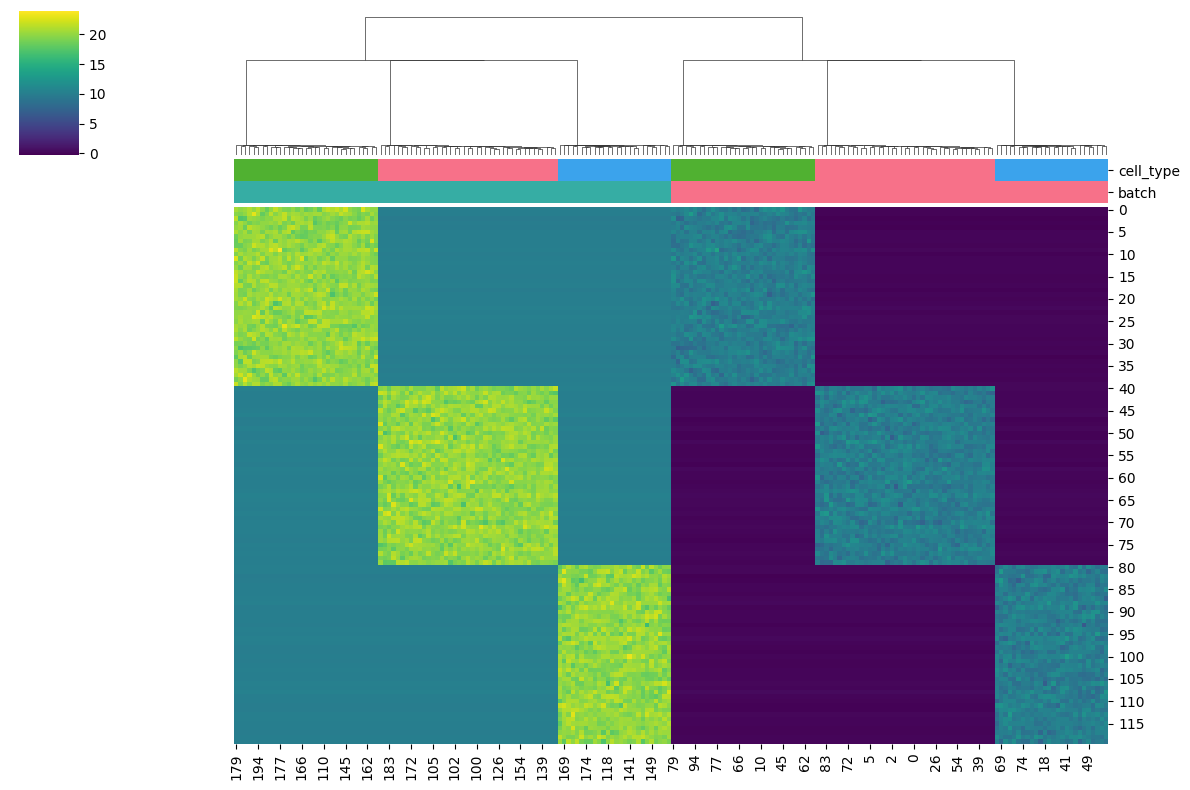

In [818]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')


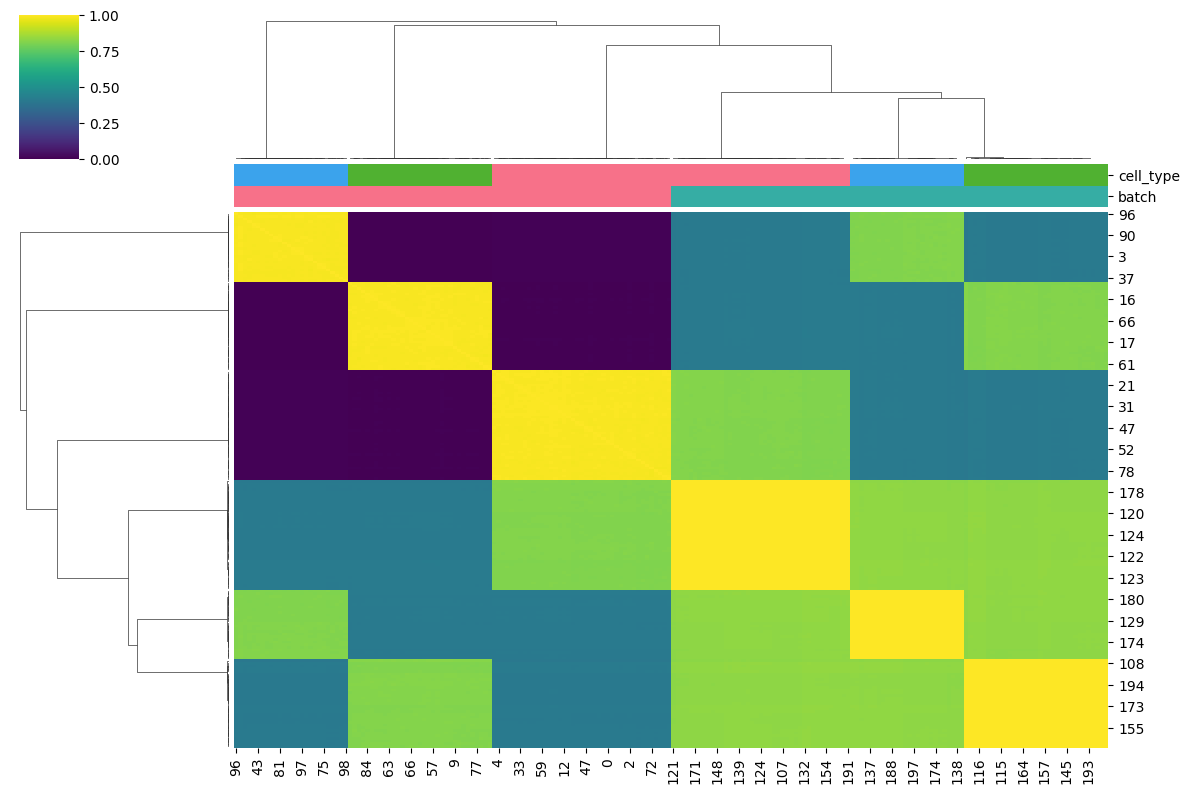

In [819]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png') 

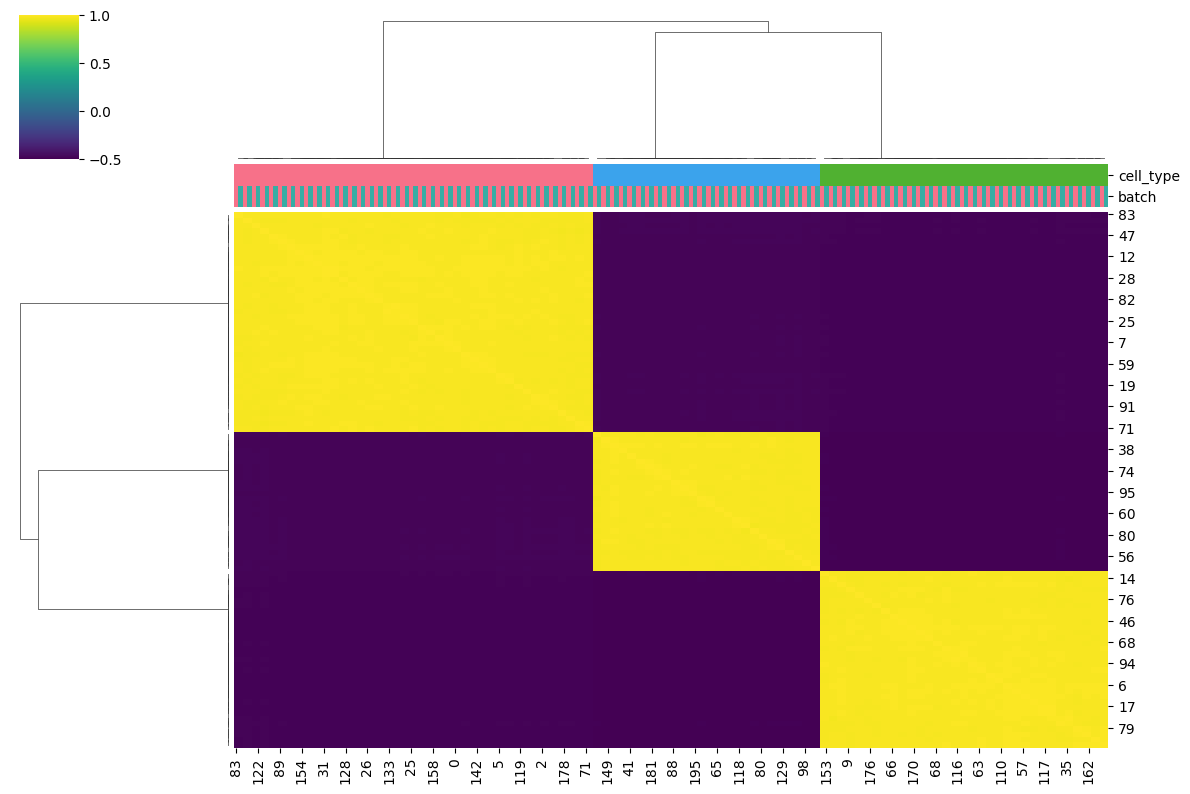

In [820]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

## Test batch correction

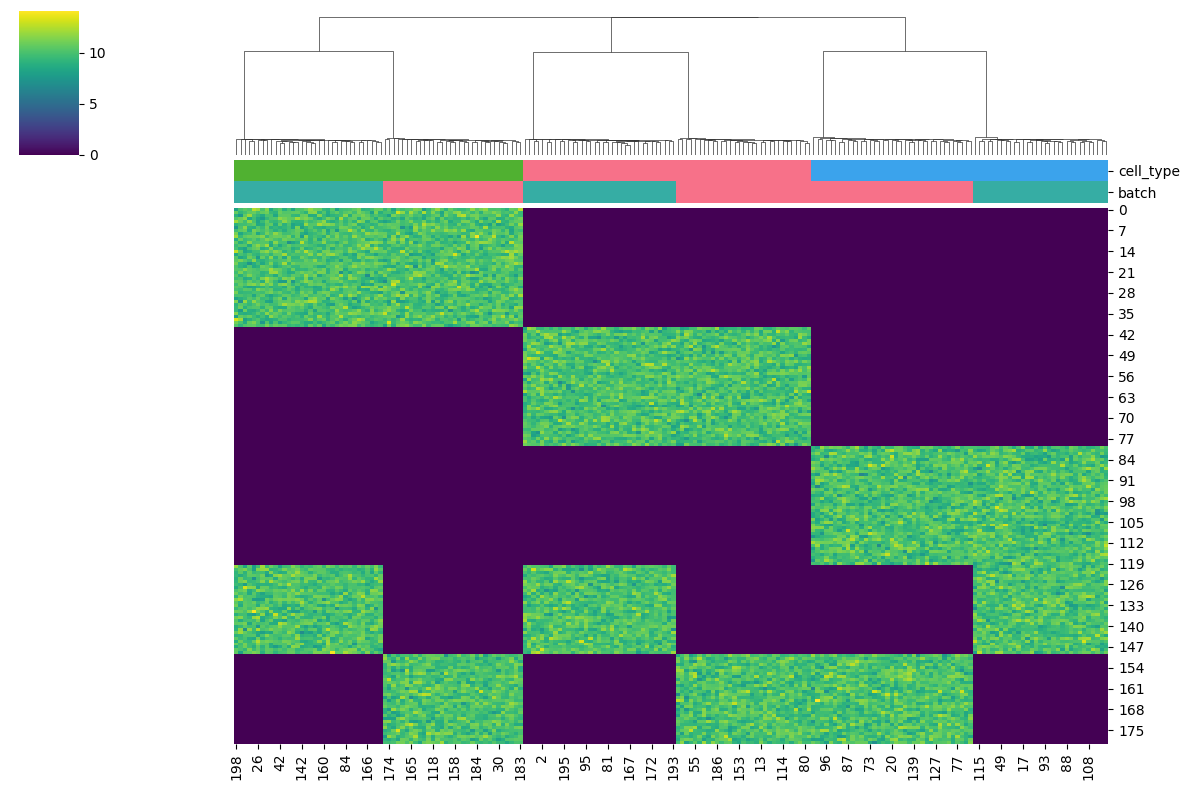

In [117]:
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis')


### No correction

In [122]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.1)

In [123]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

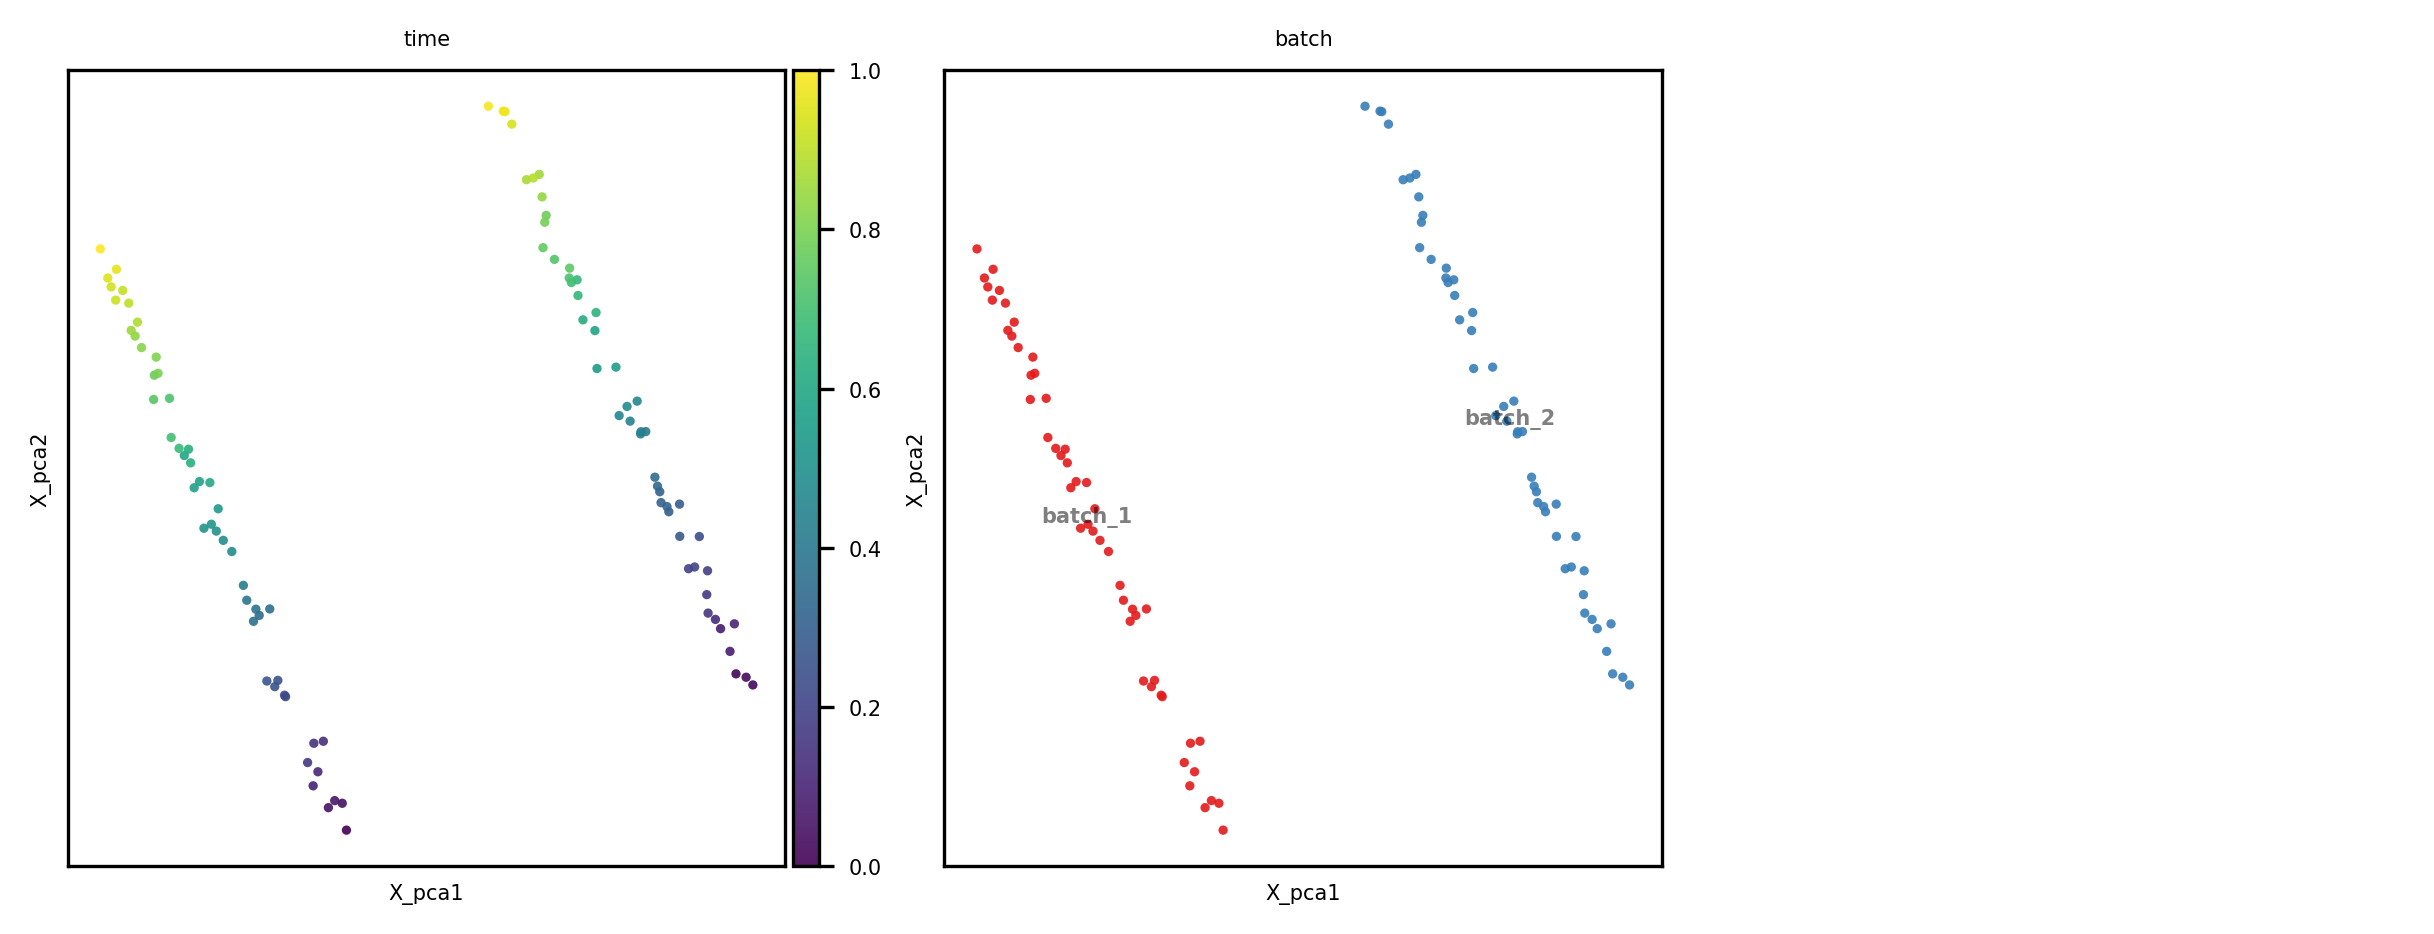

In [124]:
show_basis = 'X_pca'
show_cols = [group_key, batch_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{show_basis}_{file_suffix}.png"
)

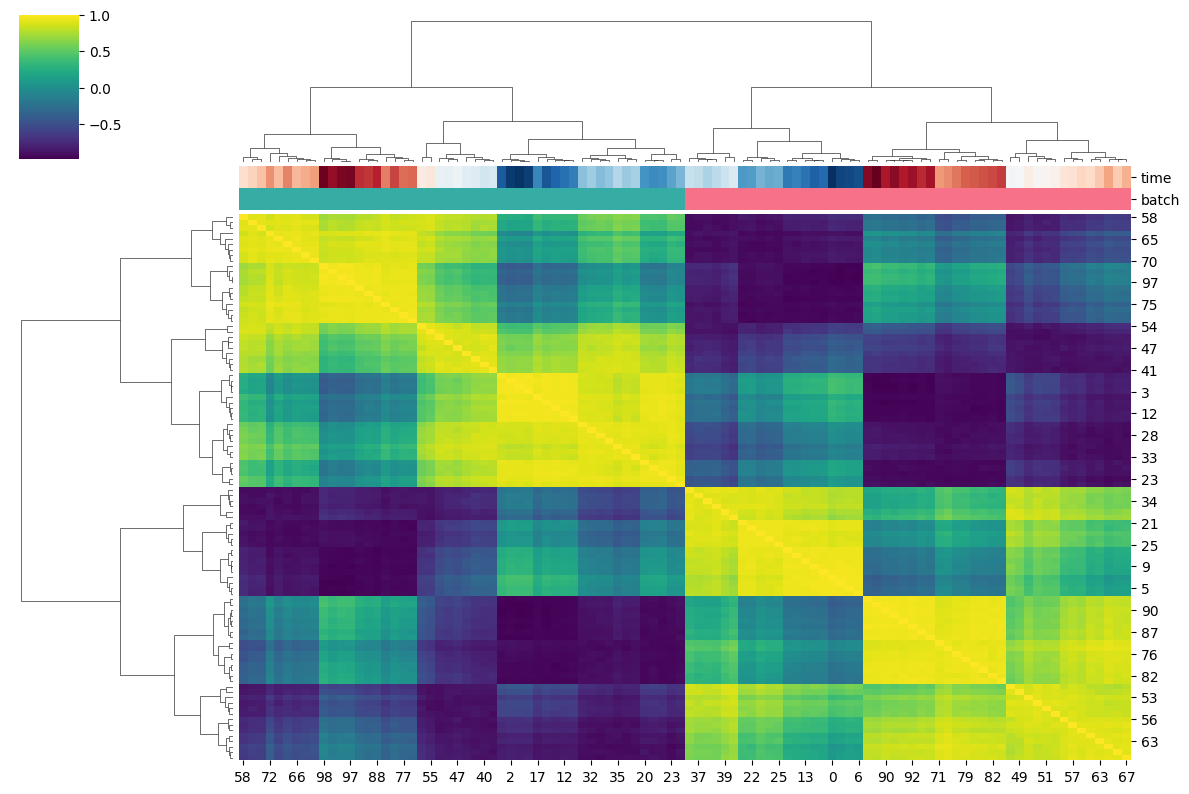

In [125]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.obsm[show_basis], rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_{show_basis}_correlation_{file_suffix}.png')

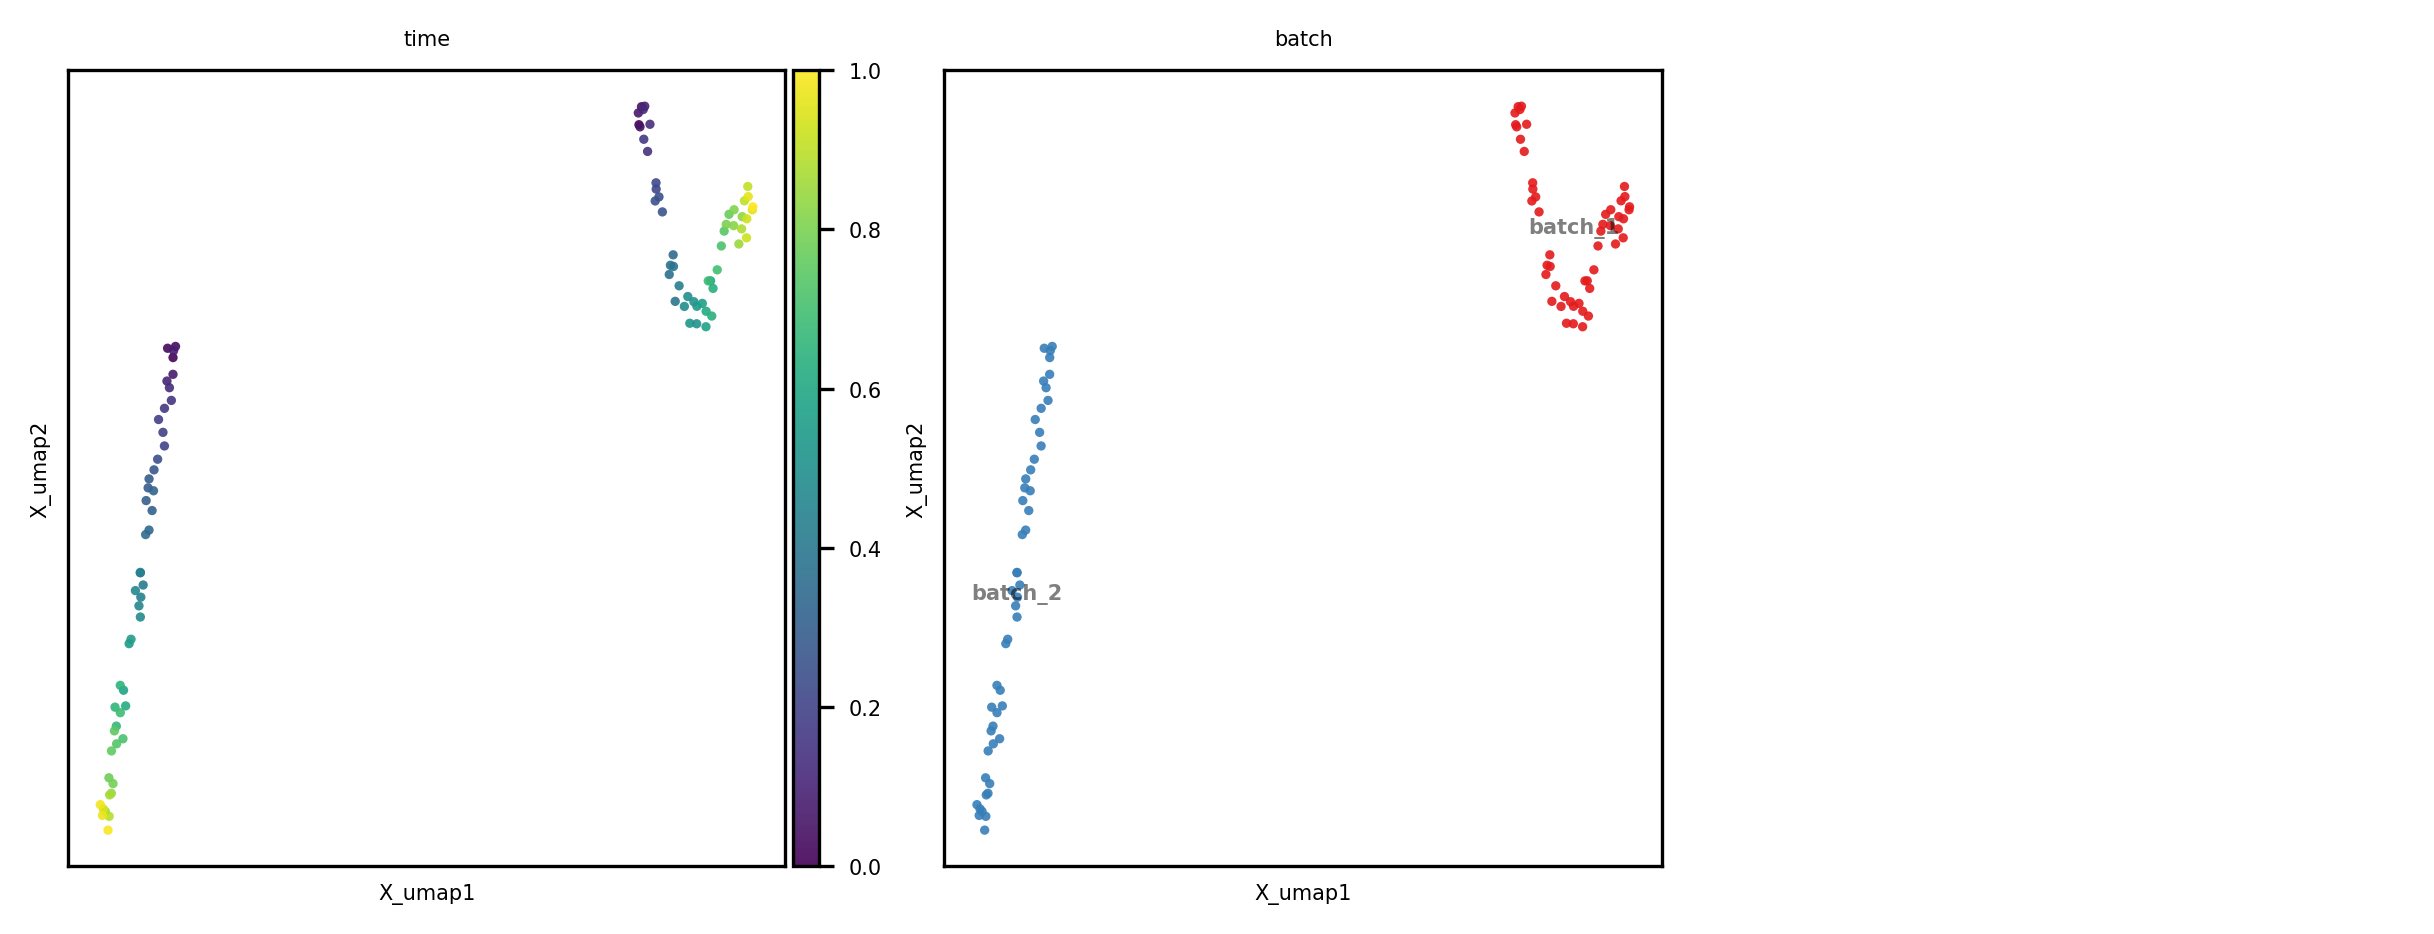

In [126]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{show_basis}_{file_suffix}.png"
)

### Concord

In [234]:
import importlib
importlib.reload(ccd)

<module 'Concord' from '/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/Concord/__init__.py'>

['batch_2', 'batch_1']
Categories (2, object): ['batch_1', 'batch_2']


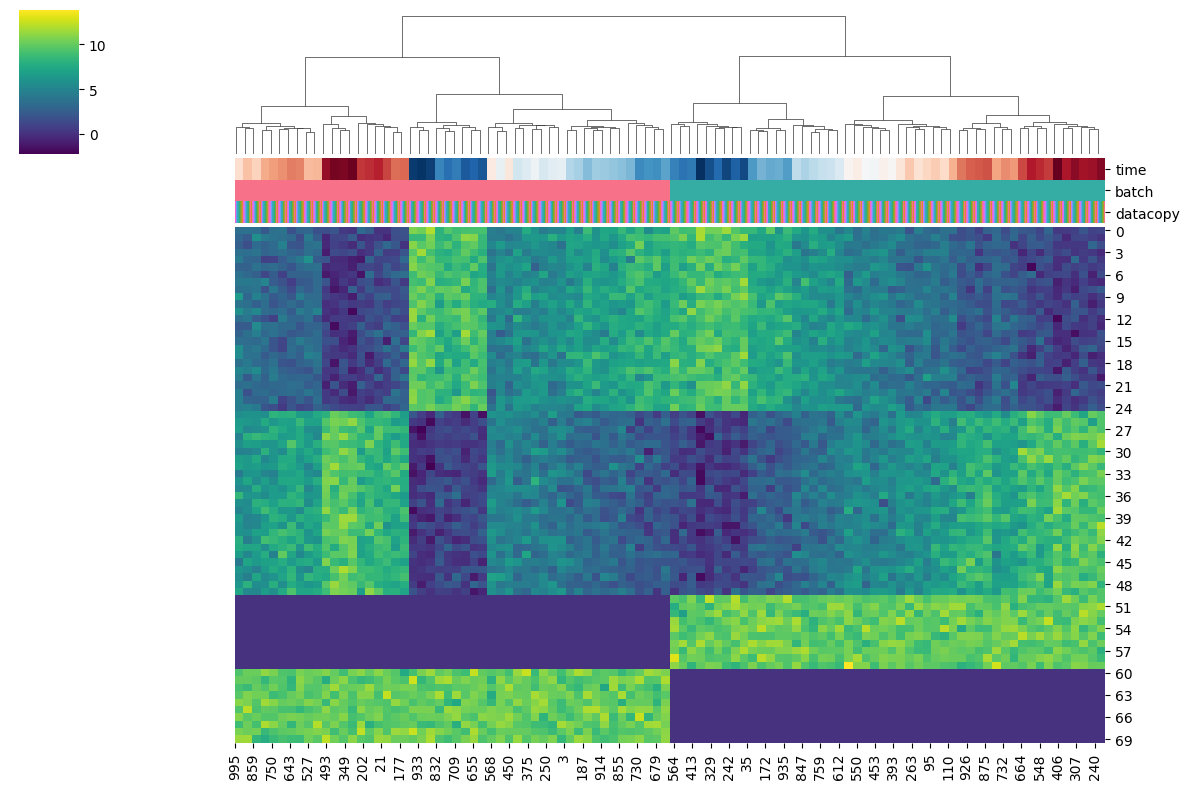

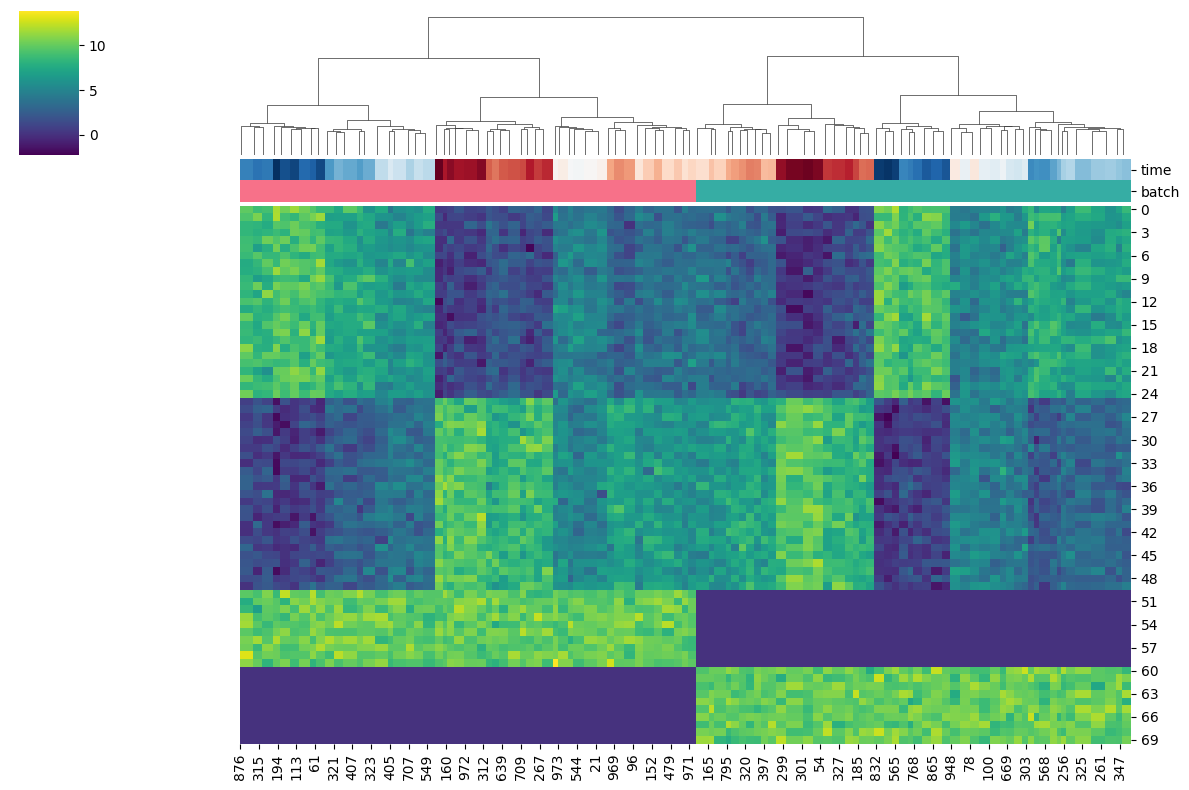

In [212]:
# Example usage
from simulation import permute_and_concatenate_adata_independent
adata_permuted = permute_and_concatenate_adata_independent(adata, x=10)
ccd.pl.heatmap_with_annotations(adata_permuted, val='X', obs_keys=[group_key, batch_key, 'datacopy'], cluster_cols=True, cluster_rows=False, cmap='viridis')
ncells_sample = adata.shape[0] * 10
adata_sampled = adata.copy()[np.random.choice(adata.obs_names, ncells_sample, replace=True), :]
ccd.pl.heatmap_with_annotations(adata_sampled, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis')

In [311]:
import importlib
importlib.reload(ccd)

<module 'Concord' from '/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/Concord/__init__.py'>

In [398]:
#amp_mode = 'permute'
#amp_mode = 'sample'
amp_mode = 'none'
adata_train = adata_permuted if amp_mode == 'permute' else adata_sampled if amp_mode == 'sample' else adata
    
cur_ccd = ccd.Concord(adata=adata_train, 
                      input_feature=None, 
                      batch_size=10,
                      n_epochs=10,
                      lr=1e-2,
                      schedule_ratio = 0.99,
                      latent_dim=10, # latent dimension
                      encoder_dims = [30], # encoder architecture
                      decoder_dims = [30], # decoder architecture
                      norm_type = 'layer_norm',
                      use_importance_mask=False,
                      #importance_penalty_weight=1.0,
                      use_decoder=False,
                      domain_embedding_dim=8,
                      domain_key=batch_key, # key indicating batch
                      augmentation_mask_prob = 0.5, # augmentation mask probability, recommend between 0.1 and 0.7
                      clr_temperature = 0.5, # temperature for NT-Xent loss
                      seed=seed, # random seed
                      p_intra_domain = 1.0, # probability of intra-domain sampling
                      p_intra_knn=0.0,
                      sampler_knn = 100,
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{batch_mode}_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.


Epoch 0 Training: 10it [00:00, 242.76it/s, loss=2.71]
Epoch 9 Training: 100%|██████████| 10/10 [00:00<00:00, 256.34it/s, loss=2.5]


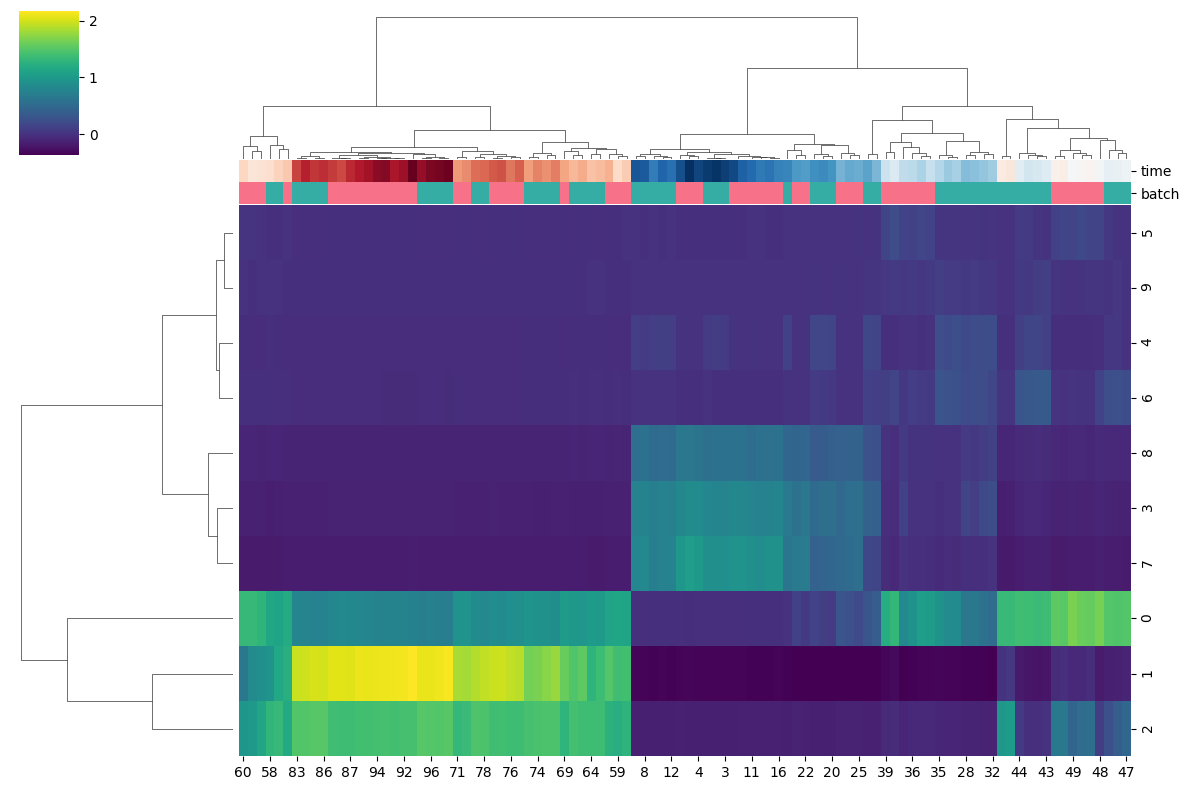

In [394]:
# Take the subset 
if amp_mode == 'permute':
    adata_plot = cur_ccd.adata.copy()[cur_ccd.adata.obs['datacopy'] == '0', :] 
elif amp_mode == 'sample':
    unique_obs_names, unique_indices = np.unique(cur_ccd.adata.obs_names, return_index=True)
    adata_plot = cur_ccd.adata[unique_indices, :].copy()
    print(adata_plot.shape)
else:
    adata_plot = cur_ccd.adata.copy()

ccd.pl.heatmap_with_annotations(adata_plot, val='Concord', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_{amp_mode}_Concord_heatmap_{file_suffix}.png')

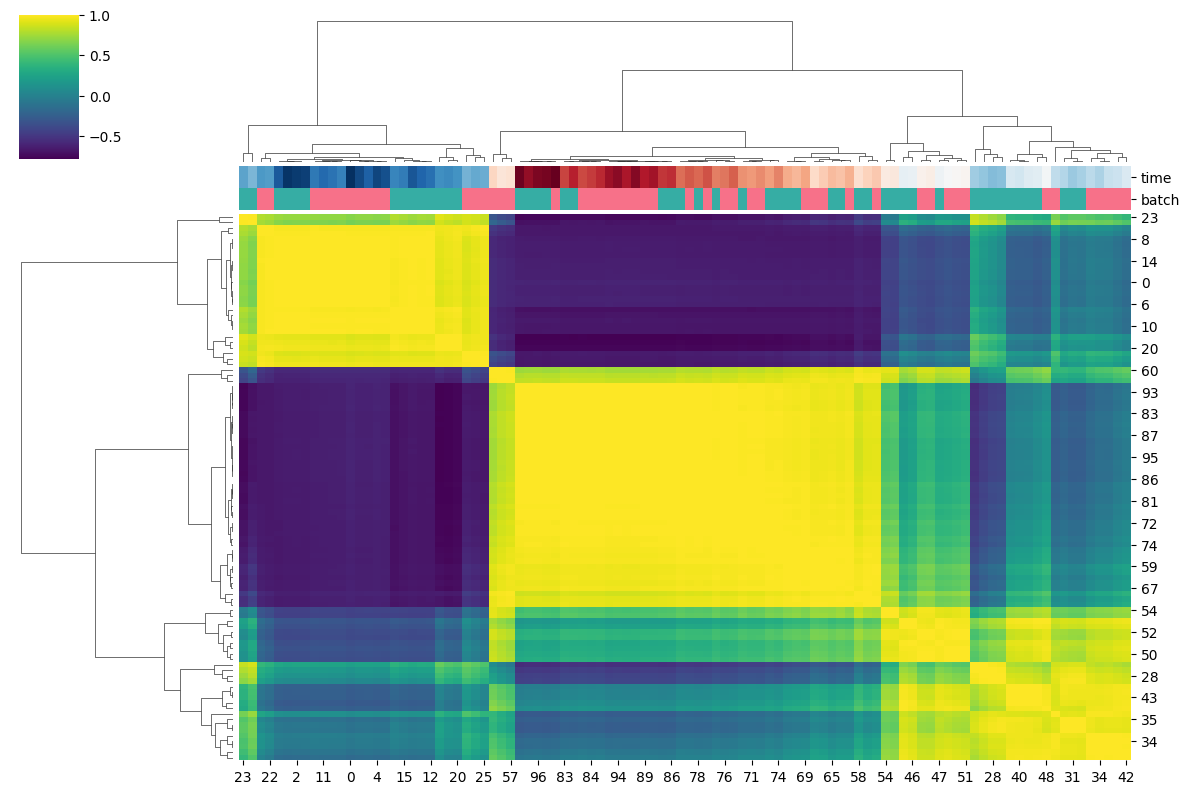

In [395]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata_plot.obsm['Concord'], rowvar=True)
ccd.pl.heatmap_with_annotations(adata_plot, val=cor_mtx,
                                obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_{amp_mode}_Concord_correlation_{file_suffix}.png')

In [2]:
n_pc = min(adata_plot.obsm[output_key].shape[1], adata_plot.shape[0]) - 1
ccd.ul.run_pca(adata_plot, source_key=output_key, result_key=f'{output_key}_PCA', n_pc=n_pc, random_state=seed)
show_basis = f'{output_key}_PCA'
show_cols = [group_key, batch_key]
ccd.pl.plot_embedding(
    adata_plot, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{amp_mode}_{show_basis}_{file_suffix}.png"
)

NameError: name 'adata_plot' is not defined

In [1]:
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
output_key = 'Concord'
show_basis = f'{output_key}_UMAP'
show_cols = [group_key, batch_key]
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{amp_mode}_{show_basis}_{file_suffix}.png"
)

NameError: name 'ccd' is not defined